In [1]:
import os
import numpy as np 
import itertools
import matplotlib
from glob import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.markers import MarkerStyle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def new_rcParams(width='column'):
    
    scale_factor = 2

    if width == 'column':
        fig_width_pt = scale_factor*246.0
        fs = scale_factor*7.96
        aspect_ratio=(1 + 5 ** 0.5) / 2/1.25
    elif width == 'page':
        fig_width_pt = scale_factor*510.0
        fs = scale_factor*9
        aspect_ratio=2.5
    inches_per_pt = 1.0/72.27

    fig_width = fig_width_pt*inches_per_pt
    fig_height = fig_width/aspect_ratio

    figsize = (fig_width, fig_height)

    new_params = {}
    new_params['figure.figsize'] = figsize
    new_params['font.size'] = fs
    new_params['text.usetex'] = True
    new_params['text.latex.preamble'] = r'\usepackage{mathrsfs}\usepackage{amsmath}\usepackage{amssymb}'
    new_params['axes.labelsize'] = 'medium'
    new_params['font.family'] = 'serif'
    #new_params['font.serif'] = 'times'
    #new_params['mathtext.fontset'] = 'stix'
    new_params['xtick.direction'] = 'in'
    new_params['ytick.direction'] = 'in'
    new_params['xtick.minor.visible'] = True
    new_params['ytick.minor.visible'] = True
    new_params['legend.fontsize'] = 'medium'
    new_params['legend.handlelength'] = 1.5
    
    return new_params

color_palette = {
    'primary': '#0072B2',
    'secondary':  '#CC79A7',
    'tertiary': '#009E73',
    'color3'    : '#D55E00',
    'color4'    : '#56B4E9',
    'color5'    : '#40B0A6',
    'color6'    : '#E69F00',
    'color7'    : '#DC3220',
    'LLO': '#3953a4',
    'LHO': '#ed2024',
    'colormap': 'viridis'
}

import matplotlib.pyplot as plt
plt.rcParams.update(new_rcParams())

## Injections

In [3]:
indices_singles_a = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population_injections/SINGLES_A_*.npy')]
indices_singles_b = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population_injections/SINGLES_B_*.npy')]
indices_match = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population/FF_2D_H1_*.npy')]
indices_ml = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population/FF_ML_4D_H1_*.npy')]
indices_ml2 = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population/FF_SL_2D_H1_*.npy')]
indices_ml2c = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population/FF_SLC_3D_H1_*.npy')]
indices_ecc = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population/FF_ECC_3D_H1_*.npy')]
indices_ecc_0 = [int(f.split('_')[-1].split('.')[0]) for f in glob('../../output/pe_population/population/FF_ECC_0_2D_H1_*.npy')]

indices = list(set(indices_singles_a).intersection(indices_singles_b).intersection(indices_match).intersection(indices_ml).intersection(indices_ml2).intersection(indices_ml2c))#.intersection(indices_ecc).intersection(indices_ecc_0))

In [4]:
data_a, data_b = [], []
mchirp_a, mchirp_b = np.zeros(len(indices)), np.zeros(len(indices))
eta_a, eta_b = np.zeros(len(indices)), np.zeros(len(indices))
eff_spin_a, eff_spin_b = np.zeros(len(indices)), np.zeros(len(indices))
delta_tc, snr_a, snr_b, snr_ratio = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))

for i in range(len(indices)):
    data_a.append(np.load('../../output/pe_population/population_injections/SINGLES_A_{}.npy'.format(indices[i]), allow_pickle=True).item())
    data_b.append(np.load('../../output/pe_population/population_injections/SINGLES_B_{}.npy'.format(indices[i]), allow_pickle=True).item())

    mchirp_a[i], mchirp_b[i] = np.power(data_a[i]['mass_1']*data_a[i]['mass_2'], (3/5))/np.power(data_a[i]['mass_1']+data_a[i]['mass_2'], (1/5)), np.power(data_b[i]['mass_1']*data_b[i]['mass_2'], (3/5))/np.power(data_b[i]['mass_1']+data_b[i]['mass_2'], (1/5))
    eta_a[i], eta_b[i] = (data_a[i]['mass_1']*data_a[i]['mass_2'])/np.power(data_a[i]['mass_1']+data_a[i]['mass_2'], 2), (data_b[i]['mass_1']*data_b[i]['mass_2'])/np.power(data_b[i]['mass_1']+data_b[i]['mass_2'], 2)
    eff_spin_a[i], eff_spin_b[i] = data_a[i]['a_1'], data_b[i]['a_1']

    delta_tc[i] = data_b[i]['geocent_time'] - data_a[i]['geocent_time']
    snr_a[i], snr_b[i] = data_a[i]['snr_det'], data_b[i]['snr_det']
    snr_ratio[i] = snr_b[i]/snr_a[i]

In [5]:
mask_0 = np.where((snr_a/snr_b > 0.1) & (snr_a/snr_b < 10) & (mchirp_a/mchirp_b > 0.1) & (mchirp_a/mchirp_b < 10))[0]
mchirp_a, mchirp_b = mchirp_a[mask_0], mchirp_b[mask_0]
snr_a, snr_b = snr_a[mask_0], snr_b[mask_0]
delta_tc = delta_tc[mask_0]

## Microlensing Recovery

In [6]:
match_ml, mchirp_ml, eta_ml, Ml_z_ml, y_ml = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))
for i in range(len(indices)):
    try:
        data_H1 = np.load('../../output/pe_population/population/FF_ML_4D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml_H1, mchirp_ml_H1, eta_ml_H1, Ml_z_ml_H1, y_ml_H1 = data_H1[0], data_H1[1], data_H1[2], data_H1[3], data_H1[4]
        data_L1 = np.load('../../output/pe_population/population/FF_ML_4D_L1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml_L1, mchirp_ml_L1, eta_ml_L1, Ml_z_ml_L1, y_ml_L1 = data_L1[0], data_L1[1], data_L1[2], data_L1[3], data_L1[4]
        data_V1 = np.load('../../output/pe_population/population/FF_ML_4D_V1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml_V1, mchirp_ml_V1, eta_ml_V1, Ml_z_ml_V1, y_ml_V1 = data_V1[0], data_V1[1], data_V1[2], data_V1[3], data_V1[4]

        match_ml[i] = np.sqrt(np.median([match_ml_H1**2, match_ml_L1**2, match_ml_V1**2]))
        mchirp_ml[i] = np.median([mchirp_ml_H1, mchirp_ml_L1, mchirp_ml_V1])
        eta_ml[i] = np.median([eta_ml_H1, eta_ml_L1, eta_ml_V1])
        Ml_z_ml[i] = np.median([Ml_z_ml_H1, Ml_z_ml_L1, Ml_z_ml_V1])
        y_ml[i] = np.median([y_ml_H1, y_ml_L1, y_ml_V1])
    except:
        data = np.load('../../output/pe_population/population/FF_ML_4D_H1_{}.npy'.format(indices[i]), allow_pickle=True)    
        match_ml[i], mchirp_ml[i], eta_ml[i], Ml_z_ml[i], y_ml[i] = data[0], data[1], data[2], data[3], data[4]

In [7]:
match_ml, mchirp_ml, eta_ml, Ml_z_ml, y_ml = match_ml[mask_0], mchirp_ml[mask_0], eta_ml[mask_0], Ml_z_ml[mask_0], y_ml[mask_0]

In [8]:
bias_mchirp_a_ml = np.abs(mchirp_ml-mchirp_a)/mchirp_a*100
bias_mchirp_b_ml = np.abs(mchirp_ml-mchirp_b)/mchirp_b*100

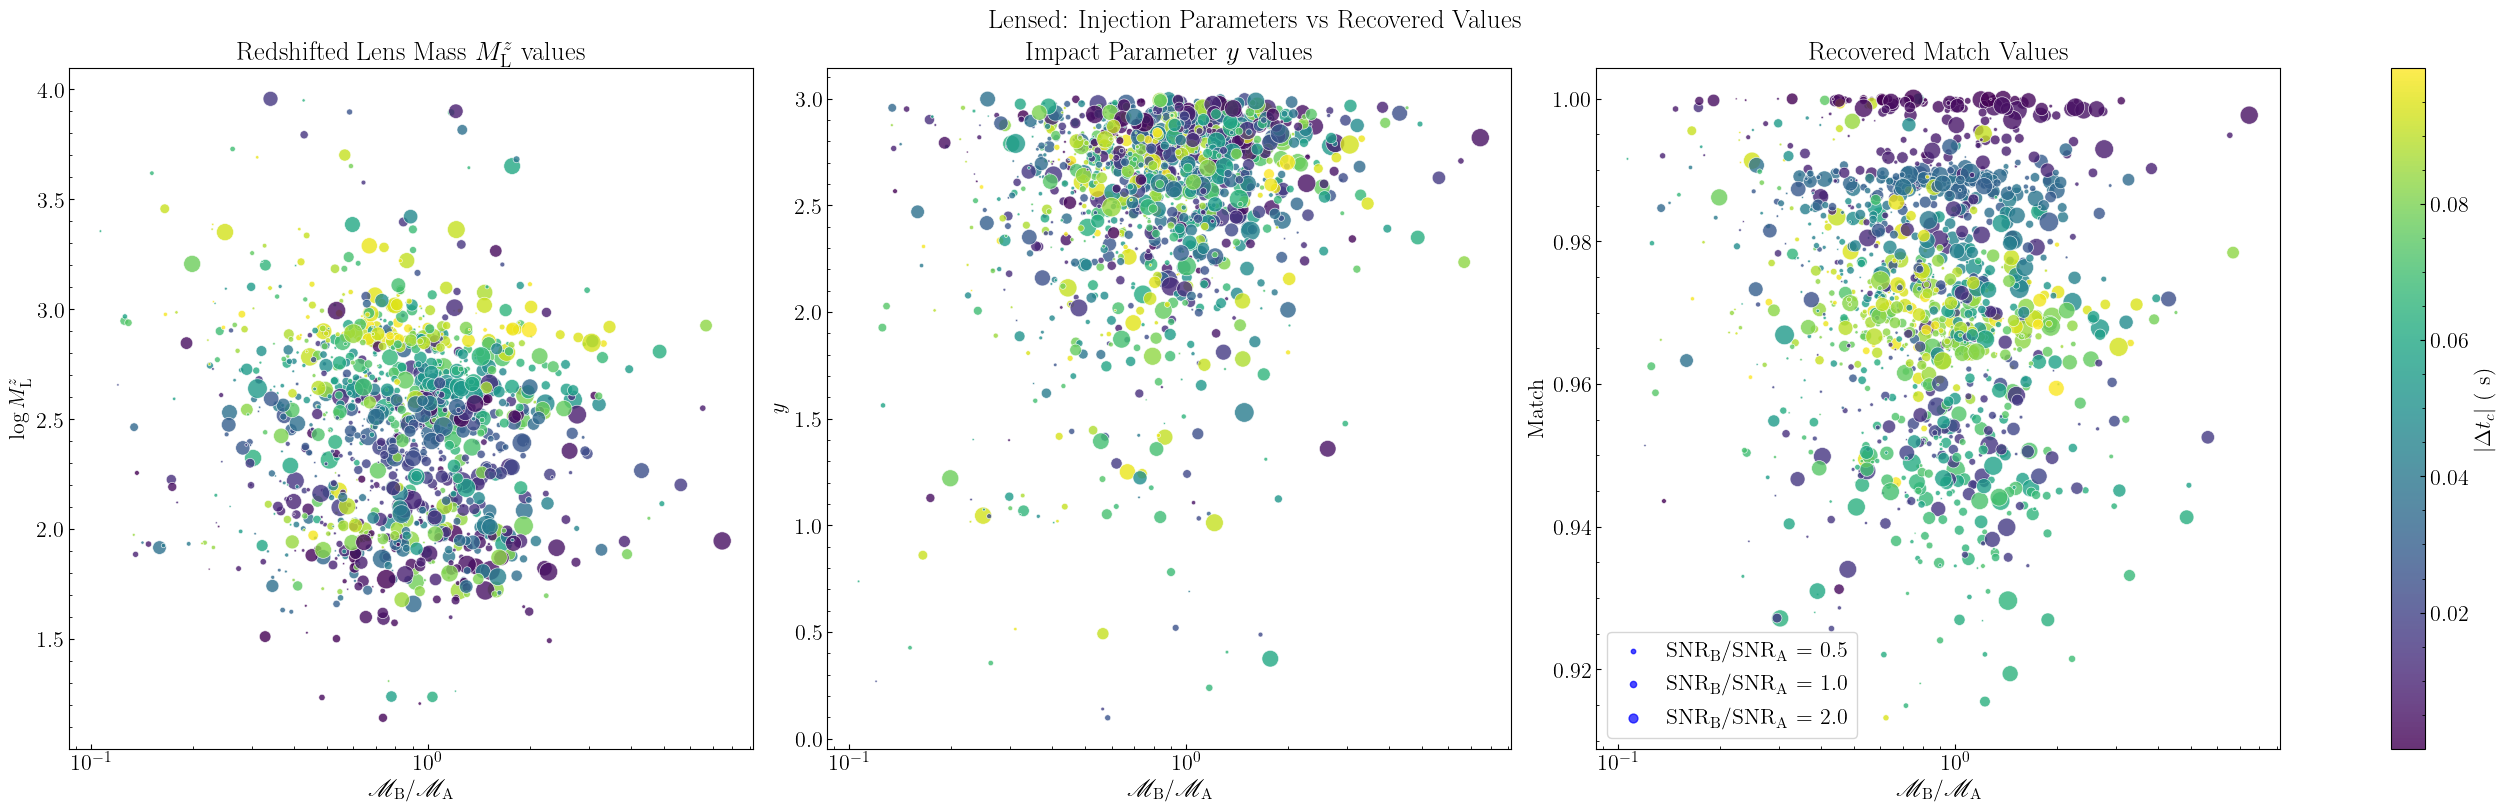

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)

sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

scatter1 = axes[0].scatter(mchirp_b/mchirp_a, np.log10(Ml_z_ml), c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('$\\log M_{\\rm L}^z$')
axes[0].set_title('Redshifted Lens Mass $M_{\\rm L}^z$ values')
axes[0].set_axisbelow(True)

scatter2 = axes[1].scatter(mchirp_b/mchirp_a, y_ml, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('$y$')
axes[1].set_title('Impact Parameter $y$ values')

axes[1].set_axisbelow(True)

scatter3 = axes[2].scatter(mchirp_b/mchirp_a, match_ml, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_ylabel('Match')
axes[2].set_title('Recovered Match Values')

axes[2].set_axisbelow(True)
cbar = plt.colorbar(scatter3, ax=[axes[0], axes[1], axes[2]])
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[2].legend(handles=snr_markers)

fig.suptitle('Lensed: Injection Parameters vs Recovered Values')
plt.show()

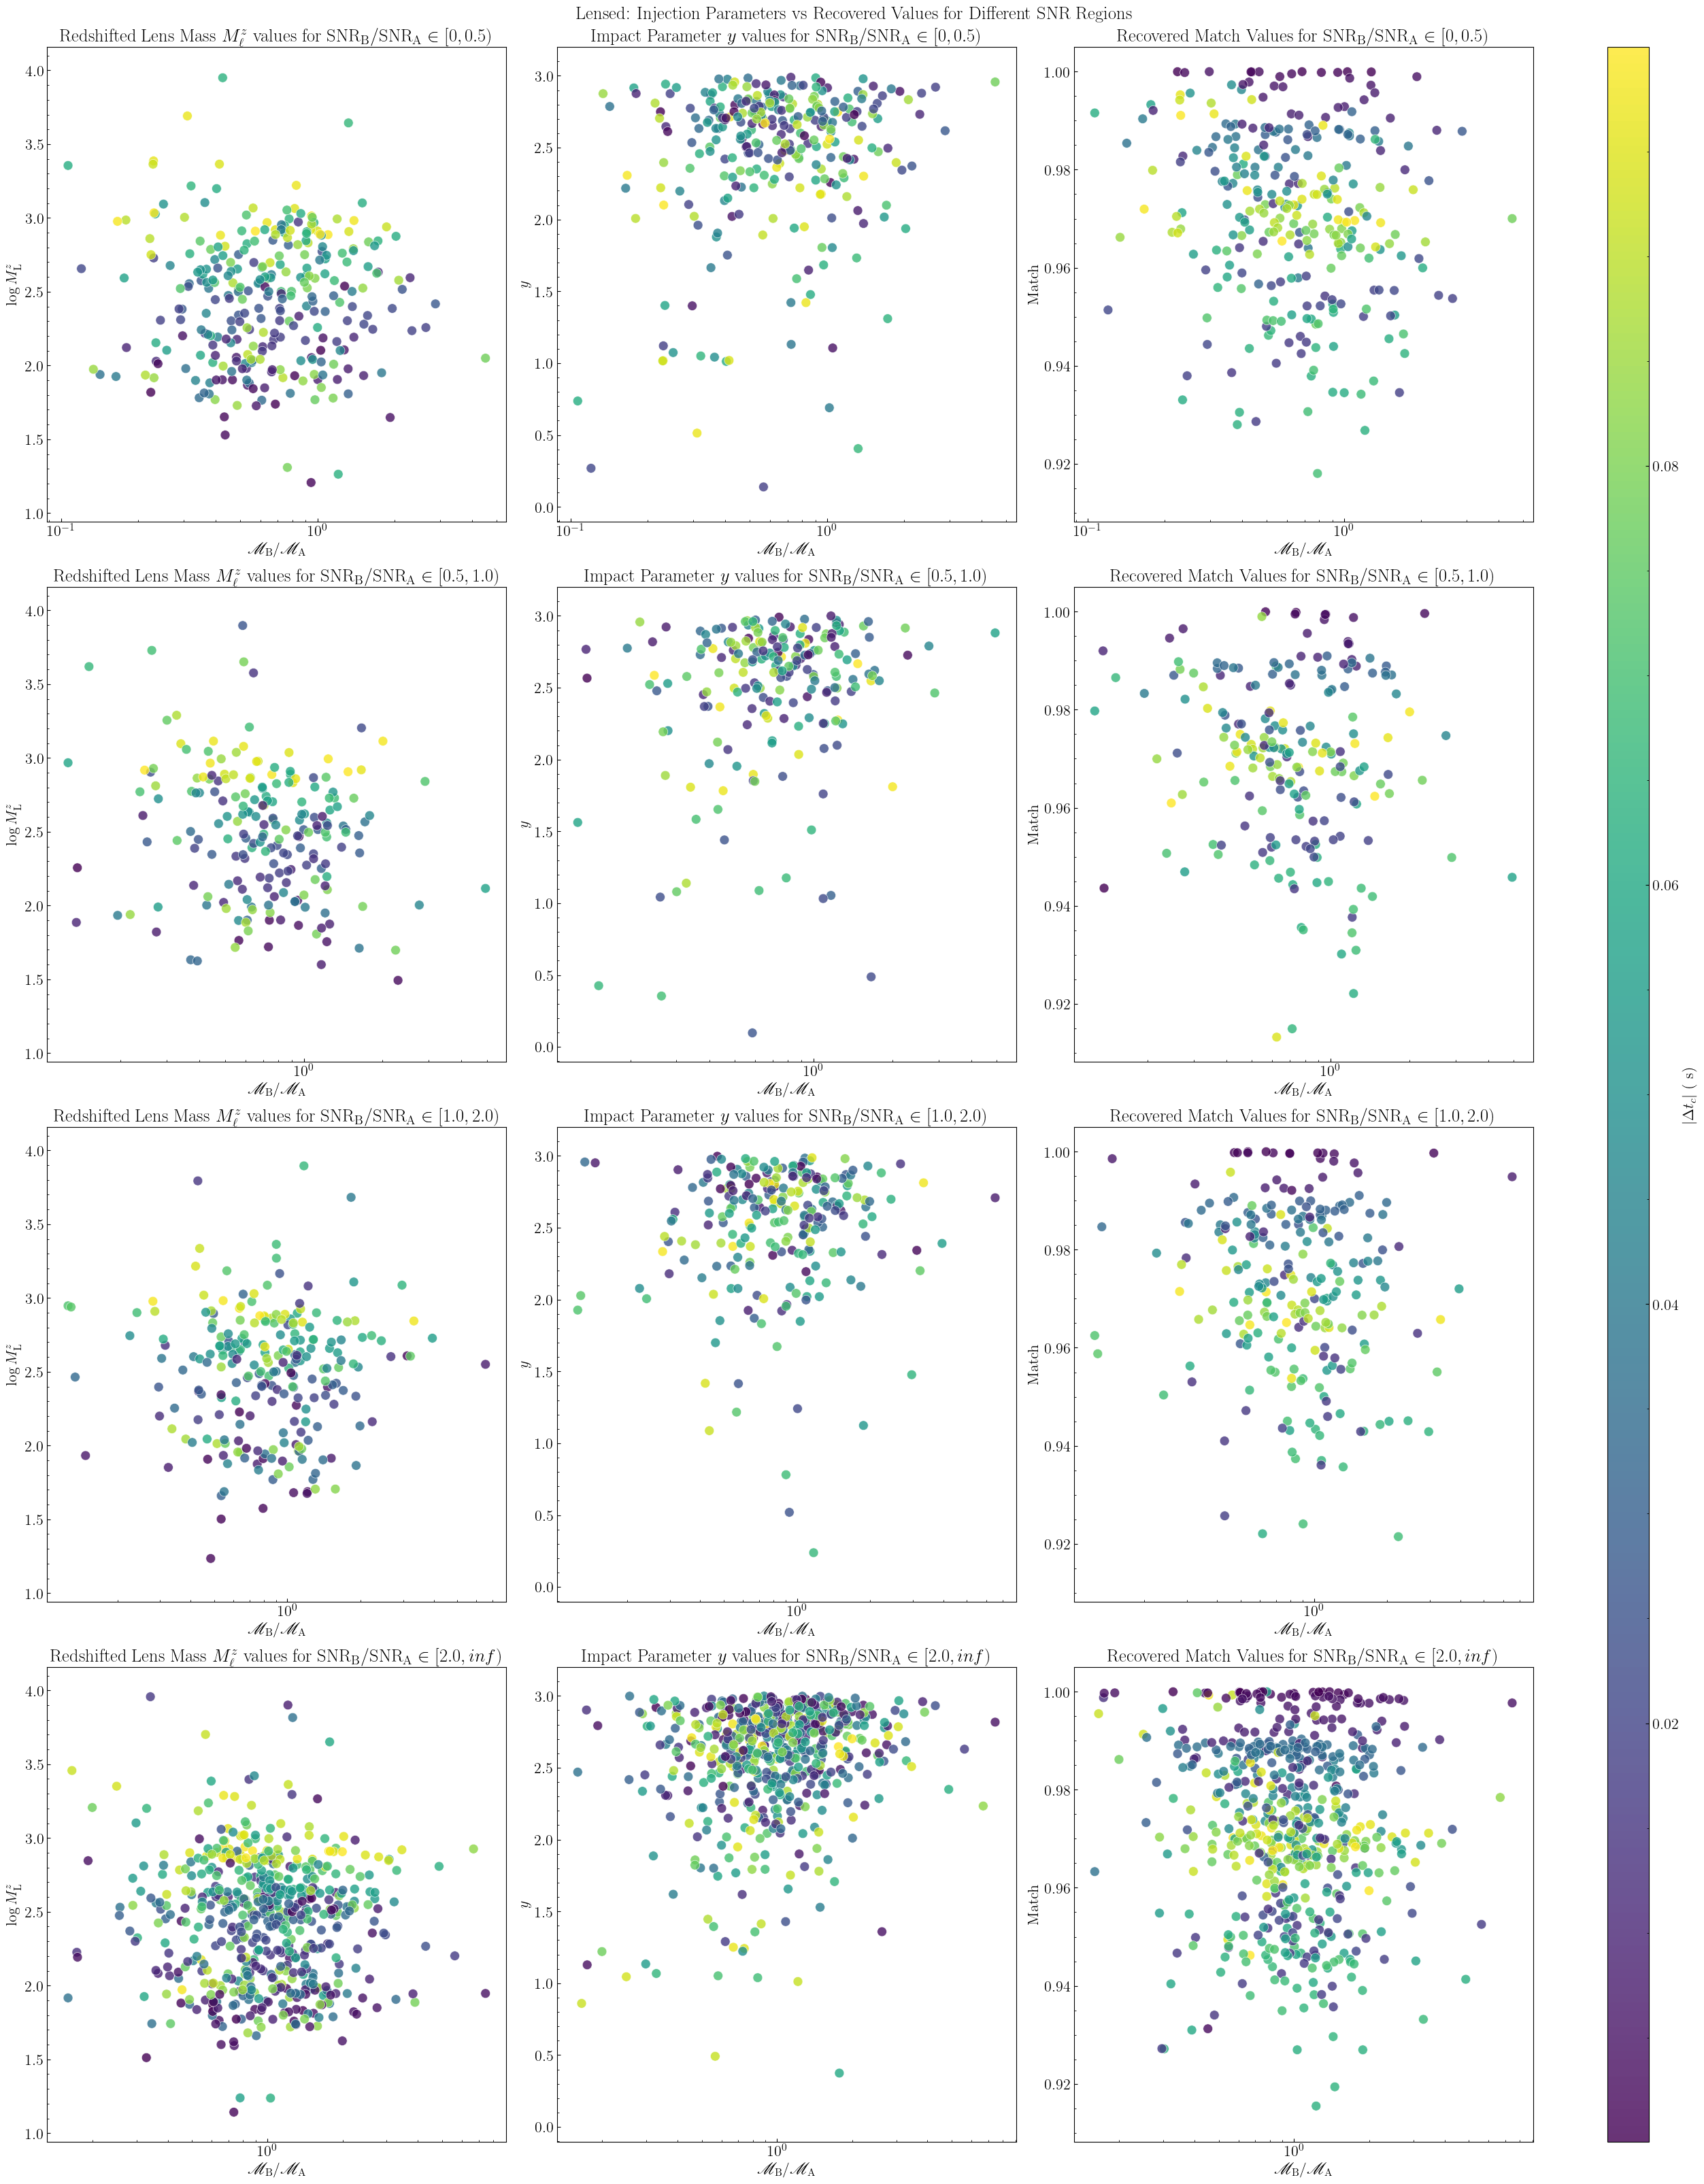

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(25, 32), constrained_layout=True)
snr_regions = [(0, 0.5), (0.5, 1.0), (1.0, 2.0), (2.0, np.inf)]

for i, (snr_min, snr_max) in enumerate(snr_regions):
    mask = (snr_b / snr_a > snr_min) & (snr_b / snr_a <= snr_max)

    scatter1 = axes[i, 0].scatter(
        mchirp_b[mask] / mchirp_a[mask], np.log10(Ml_z_ml)[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 0].set_ylabel('$\\log M_{\\rm L}^z$')
    axes[i, 0].set_title('Redshifted Lens Mass $M_{{\\ell}}^z$ values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 0].set_ylim(np.min(np.log10(Ml_z_ml))-0.2, np.max(np.log10(Ml_z_ml))+0.2)

    scatter2 = axes[i, 1].scatter(
        mchirp_b[mask] / mchirp_a[mask], y_ml[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 1].set_ylabel('$y$')
    axes[i, 1].set_title('Impact Parameter $y$ values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 1].set_ylim(np.min(y_ml)-0.2, np.max(y_ml)+0.2)

    scatter3 = axes[i, 2].scatter(
        mchirp_b[mask] / mchirp_a[mask], match_ml[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 2].set_xscale('log')
    axes[i, 2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 2].set_ylabel('Match')
    axes[i, 2].set_title('Recovered Match Values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 2].set_ylim(np.min(match_ml)-0.005, np.max(match_ml)+0.005)

cbar = fig.colorbar(scatter3, ax=axes, location='right', aspect=50)
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')

fig.suptitle('Lensed: Injection Parameters vs Recovered Values for Different SNR Regions')
plt.show()

## Type II Lensed Recovery

In [11]:
match_ml2, mchirp_ml2, eta_ml2 = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))
for i in range(len(indices)):
    try:
        data_H1 = np.load('../../output/pe_population/population/FF_SL_2D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2_H1, mchirp_ml2_H1, eta_ml2_H1 = data_H1[0], data_H1[1], data_H1[2]
        data_L1 = np.load('../../output/pe_population/population/FF_SL_2D_L1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2_L1, mchirp_ml2_L1, eta_ml2_L1 = data_L1[0], data_L1[1], data_L1[2]
        data_V1 = np.load('../../output/pe_population/population/FF_SL_2D_V1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2_V1, mchirp_ml2_V1, eta_ml2_V1 = data_V1[0], data_V1[1], data_V1[2]

        match_ml2[i] = np.sqrt(np.median([match_ml2_H1**2, match_ml2_L1**2, match_ml2_V1**2]))
        mchirp_ml2[i] = np.median([mchirp_ml2_H1, mchirp_ml2_L1, mchirp_ml2_V1])
        eta_ml2[i] = np.median([eta_ml2_H1, eta_ml2_L1, eta_ml2_V1])
    except:
        data = np.load('../../output/pe_population/population/FF_SL_2D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2[i], mchirp_ml2[i], eta_ml2[i], = data[0], data[1], data[2]

In [12]:
match_ml2, mchirp_ml2, eta_ml2 = match_ml2[mask_0], mchirp_ml2[mask_0], eta_ml2[mask_0]

In [13]:
bias_mchirp_a_ml2 = np.abs(mchirp_ml2-mchirp_a)/mchirp_a*100
bias_mchirp_b_ml2 = np.abs(mchirp_ml2-mchirp_b)/mchirp_b*100

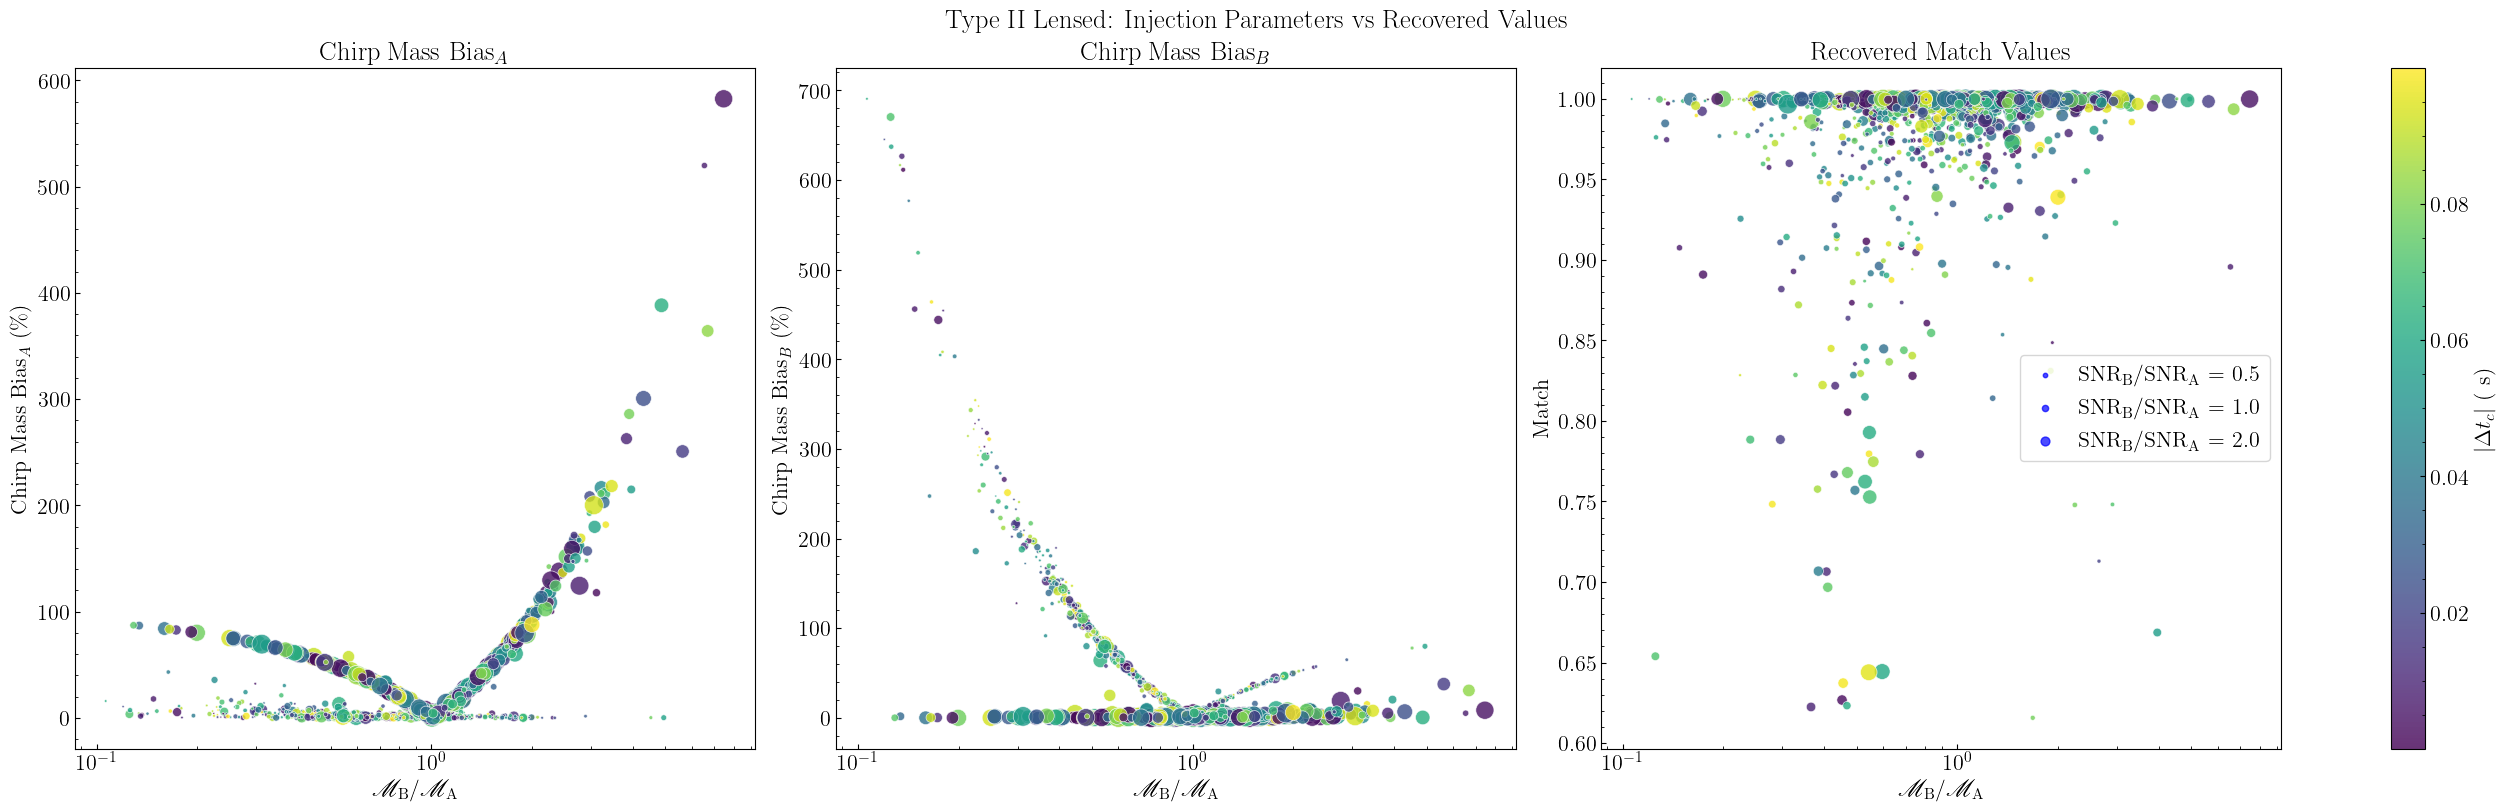

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)


sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

scatter1 = axes[0].scatter(mchirp_b/mchirp_a, bias_mchirp_a_ml2, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('Chirp Mass Bias$_A$ (\\%)')
axes[0].set_title('Chirp Mass Bias$_A$')

axes[0].set_axisbelow(True)

scatter2 = axes[1].scatter(mchirp_b/mchirp_a, bias_mchirp_b_ml2, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('Chirp Mass Bias$_B$ (\\%)')
axes[1].set_title('Chirp Mass Bias$_B$')

axes[1].set_axisbelow(True)

scatter3 = axes[2].scatter(mchirp_b/mchirp_a, match_ml2, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_ylabel('Match')
axes[2].set_title('Recovered Match Values')

axes[2].set_axisbelow(True)
cbar = plt.colorbar(scatter3, ax=[axes[0], axes[1], axes[2]])
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[2].legend(handles=snr_markers)

fig.suptitle('Type II Lensed: Injection Parameters vs Recovered Values')
plt.show()

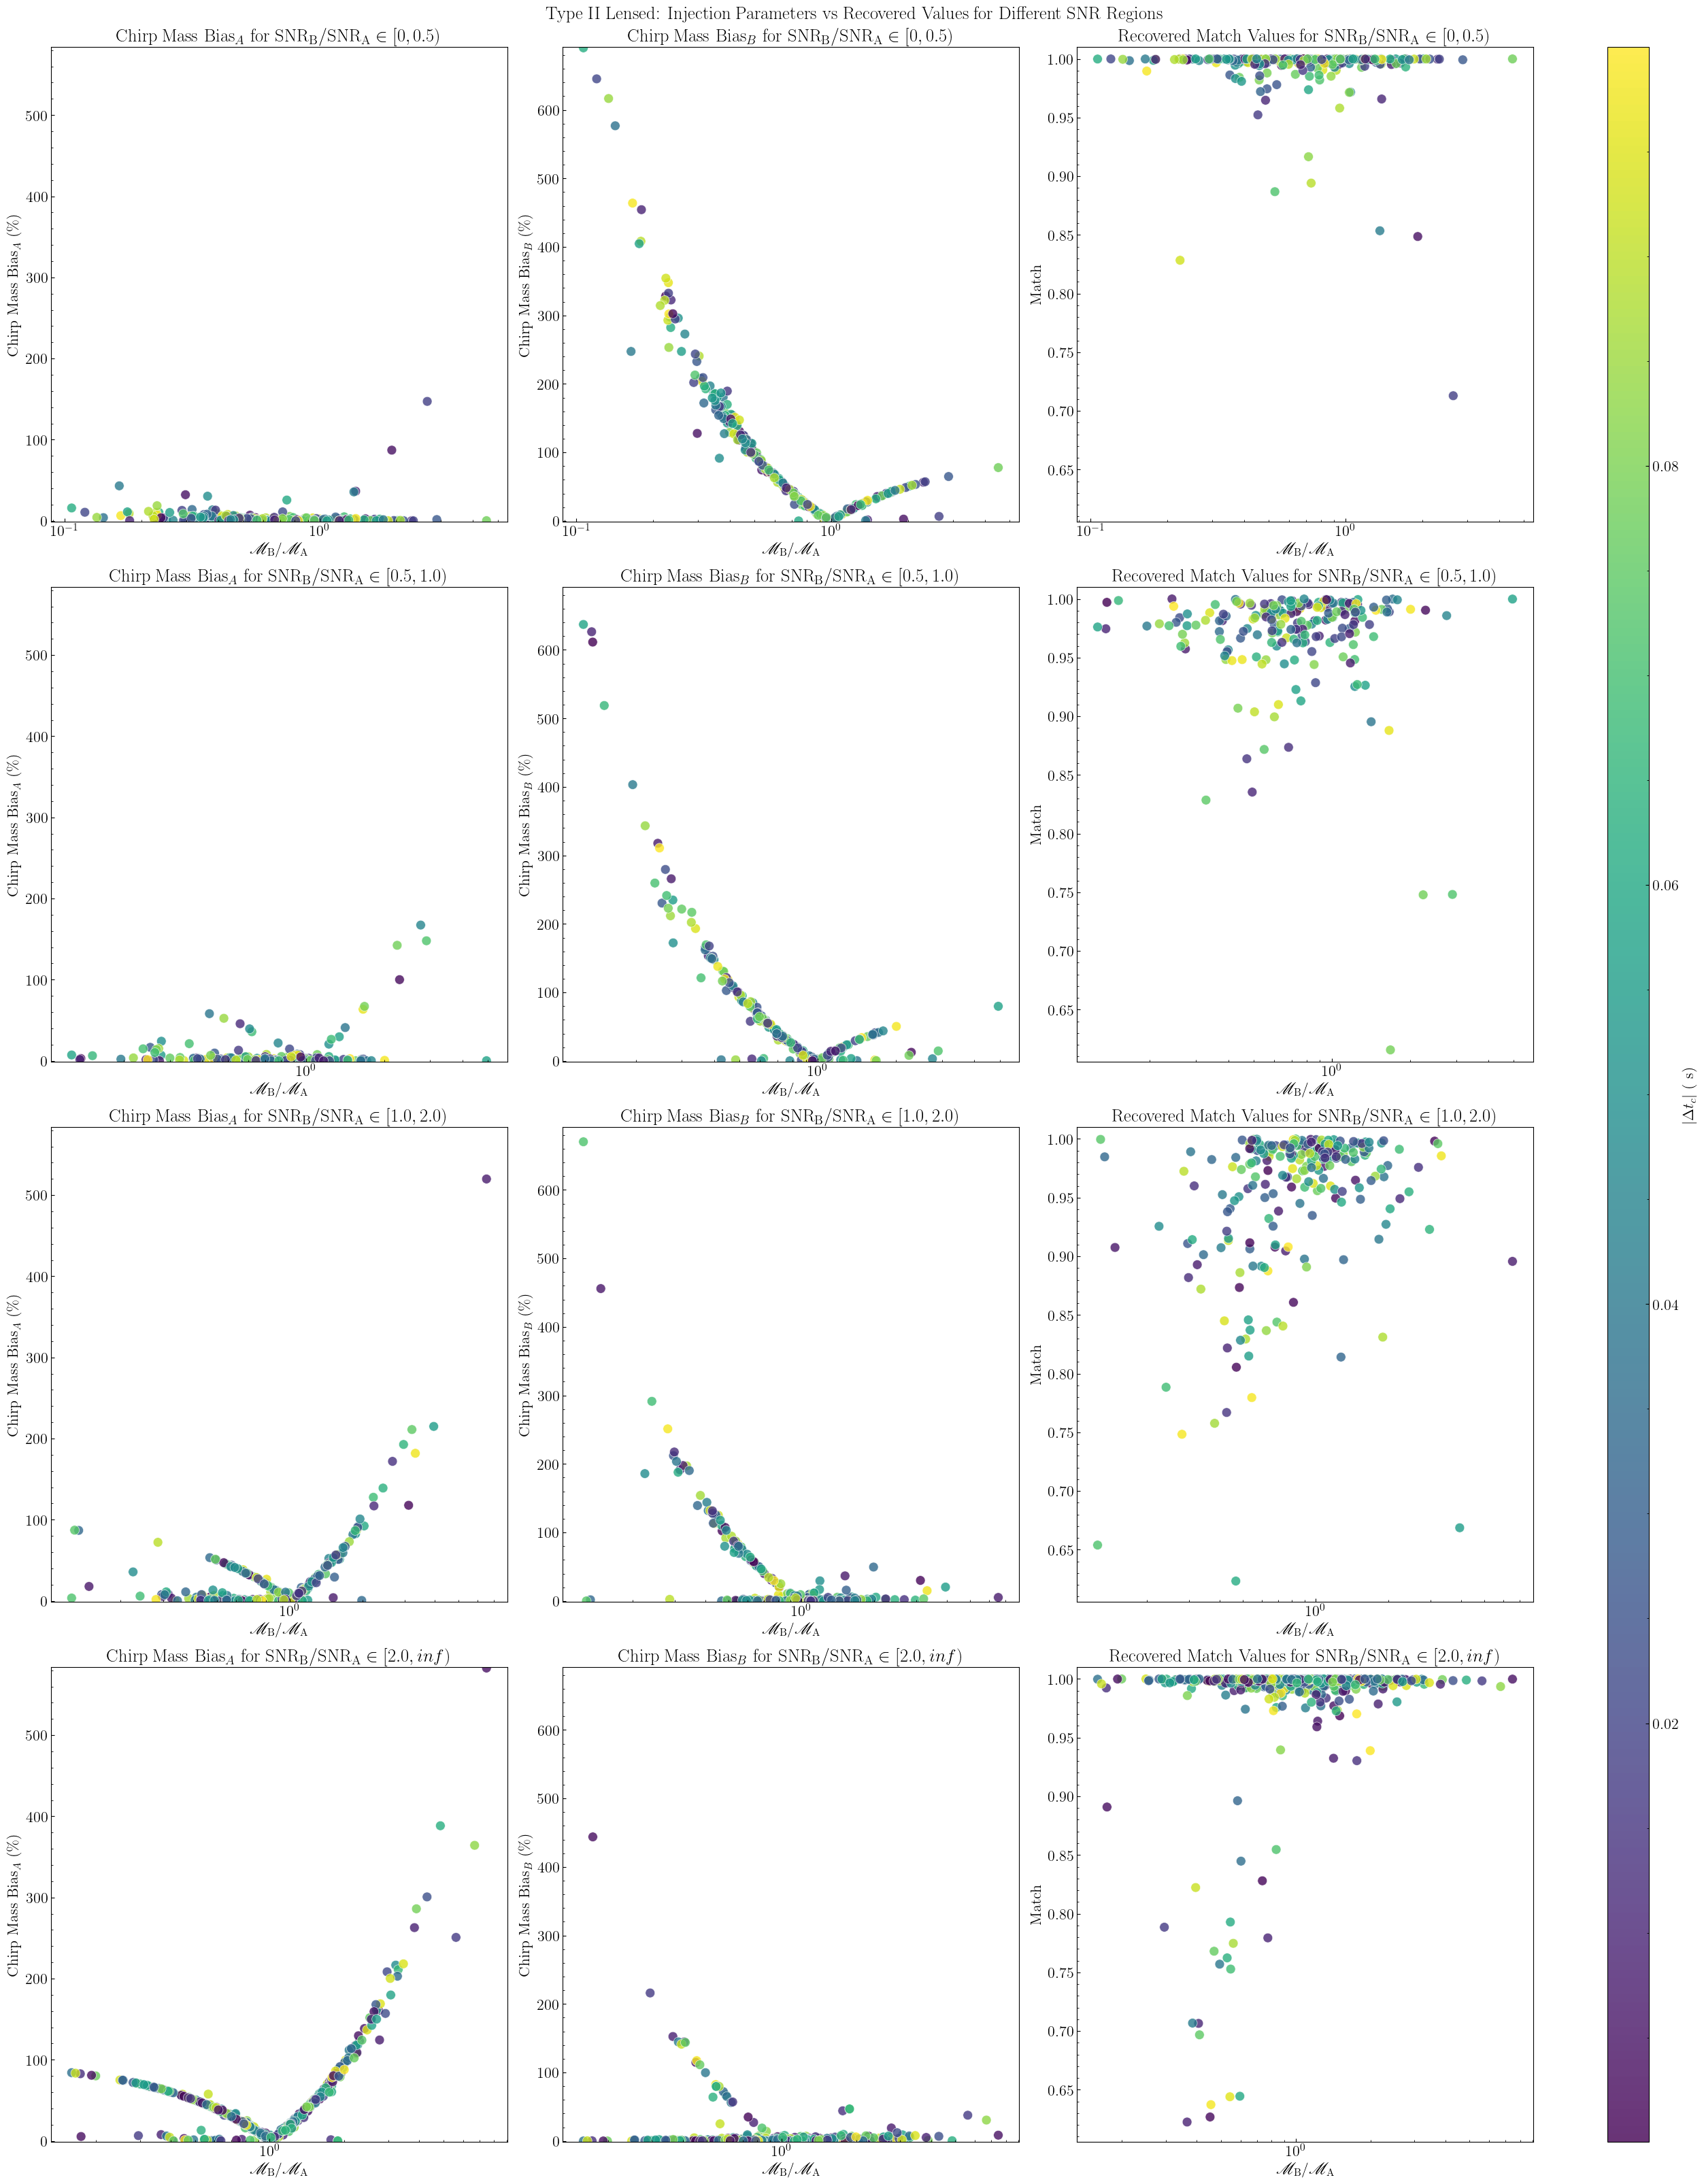

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(25, 32), constrained_layout=True)
snr_regions = [(0, 0.5), (0.5, 1.0), (1.0, 2.0), (2.0, np.inf)]



for i, (snr_min, snr_max) in enumerate(snr_regions):
    mask = (snr_b / snr_a > snr_min) & (snr_b / snr_a <= snr_max)

    scatter1 = axes[i, 0].scatter(
        mchirp_b[mask] / mchirp_a[mask], bias_mchirp_a_ml2[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 0].set_ylabel('Chirp Mass Bias$_A$ (\\%)')
    axes[i, 0].set_title('Chirp Mass Bias$_A$ for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 0].set_ylim(np.min(bias_mchirp_a_ml2)-1, np.max(bias_mchirp_a_ml2)+1)

    scatter2 = axes[i, 1].scatter(
        mchirp_b[mask] / mchirp_a[mask], bias_mchirp_b_ml2[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 1].set_ylabel('Chirp Mass Bias$_B$ (\\%)')
    axes[i, 1].set_title('Chirp Mass Bias$_B$ for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 1].set_ylim(np.min(bias_mchirp_b_ml2)-1, np.max(bias_mchirp_b_ml2)+1)

    scatter3 = axes[i, 2].scatter(
        mchirp_b[mask] / mchirp_a[mask], match_ml2[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 2].set_xscale('log')
    axes[i, 2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 2].set_ylabel('Match')
    axes[i, 2].set_title('Recovered Match Values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 2].set_ylim(np.min(match_ml2)-0.01, np.max(match_ml2)+0.01)

cbar = fig.colorbar(scatter3, ax=axes, location='right', aspect=50)
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')

fig.suptitle('Type II Lensed: Injection Parameters vs Recovered Values for Different SNR Regions')
plt.show()

## Type II Lensed (C) Recovery

In [16]:
match_ml2c, mchirp_ml2c, eta_ml2c, n_ml2c = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))
for i in range(len(indices)):
    try:
        data_H1 = np.load('../../output/pe_population/population/FF_SLC_3D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2c_H1, mchirp_ml2c_H1, eta_ml2c_H1, n_ml2c_H1 = data_H1[0], data_H1[1], data_H1[2], (data_H1[3]-1)/2
        data_L1 = np.load('../../output/pe_population/population/FF_SLC_3D_L1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2c_L1, mchirp_ml2c_L1, eta_ml2c_L1, n_ml2c_L1 = data_L1[0], data_L1[1], data_L1[2], (data_L1[3]-1)/2
        data_V1 = np.load('../../output/pe_population/population/FF_SLC_3D_V1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2c_V1, mchirp_ml2c_V1, eta_ml2c_V1, n_ml2c_V1 = data_V1[0], data_V1[1], data_V1[2], (data_V1[3]-1)/2

        match_ml2c[i] = np.sqrt(np.median([match_ml2c_H1**2, match_ml2c_L1**2, match_ml2c_V1**2]))
        mchirp_ml2c[i] = np.median([mchirp_ml2c_H1, mchirp_ml2c_L1, mchirp_ml2c_V1])
        eta_ml2c[i] = np.median([eta_ml2c_H1, eta_ml2c_L1, eta_ml2c_V1])
        n_ml2c[i] = np.median([n_ml2c_H1, n_ml2c_L1, n_ml2c_V1])
    except:
        data = np.load('../../output/pe_population/population/FF_SLC_3D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ml2c[i], mchirp_ml2c[i], eta_ml2c[i], n_ml2c[i] = data[0], data[1], data[2], (data[3]-1)/2

In [17]:
match_ml2c, mchirp_ml2c, eta_ml2c, n_ml2c = match_ml2c[mask_0], mchirp_ml2c[mask_0], eta_ml2c[mask_0], n_ml2c[mask_0]

In [18]:
bias_mchirp_a_ml2c = np.abs(mchirp_ml2c-mchirp_a)/mchirp_a*100
bias_mchirp_b_ml2c = np.abs(mchirp_ml2c-mchirp_b)/mchirp_b*100

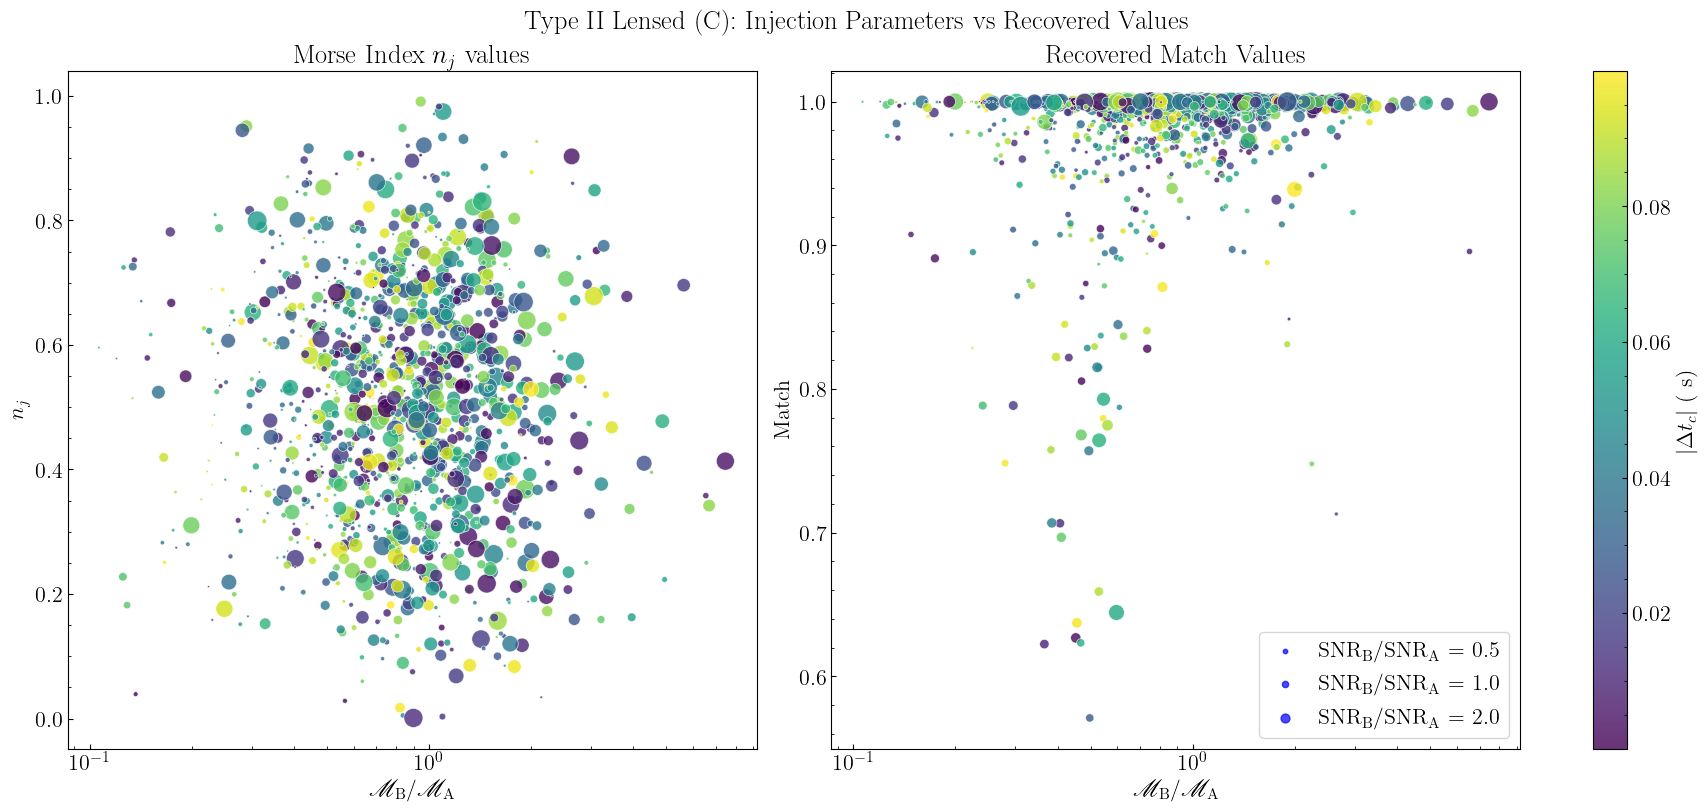

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(17, 8), constrained_layout=True)


sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

scatter1 = axes[0].scatter(mchirp_b/mchirp_a, n_ml2c, c=np.abs(delta_tc),
                        cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                        edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('$n_j$')
axes[0].set_title('Morse Index $n_j$ values')

axes[0].set_axisbelow(True)

scatter2 = axes[1].scatter(mchirp_b/mchirp_a, match_ml2c, c=np.abs(delta_tc),
                        cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                        edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('Match')
axes[1].set_title('Recovered Match Values')

axes[1].set_axisbelow(True)
cbar = plt.colorbar(scatter2, ax=[axes[0], axes[1]])
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[1].legend(handles=snr_markers)

fig.suptitle('Type II Lensed (C): Injection Parameters vs Recovered Values')
plt.show()

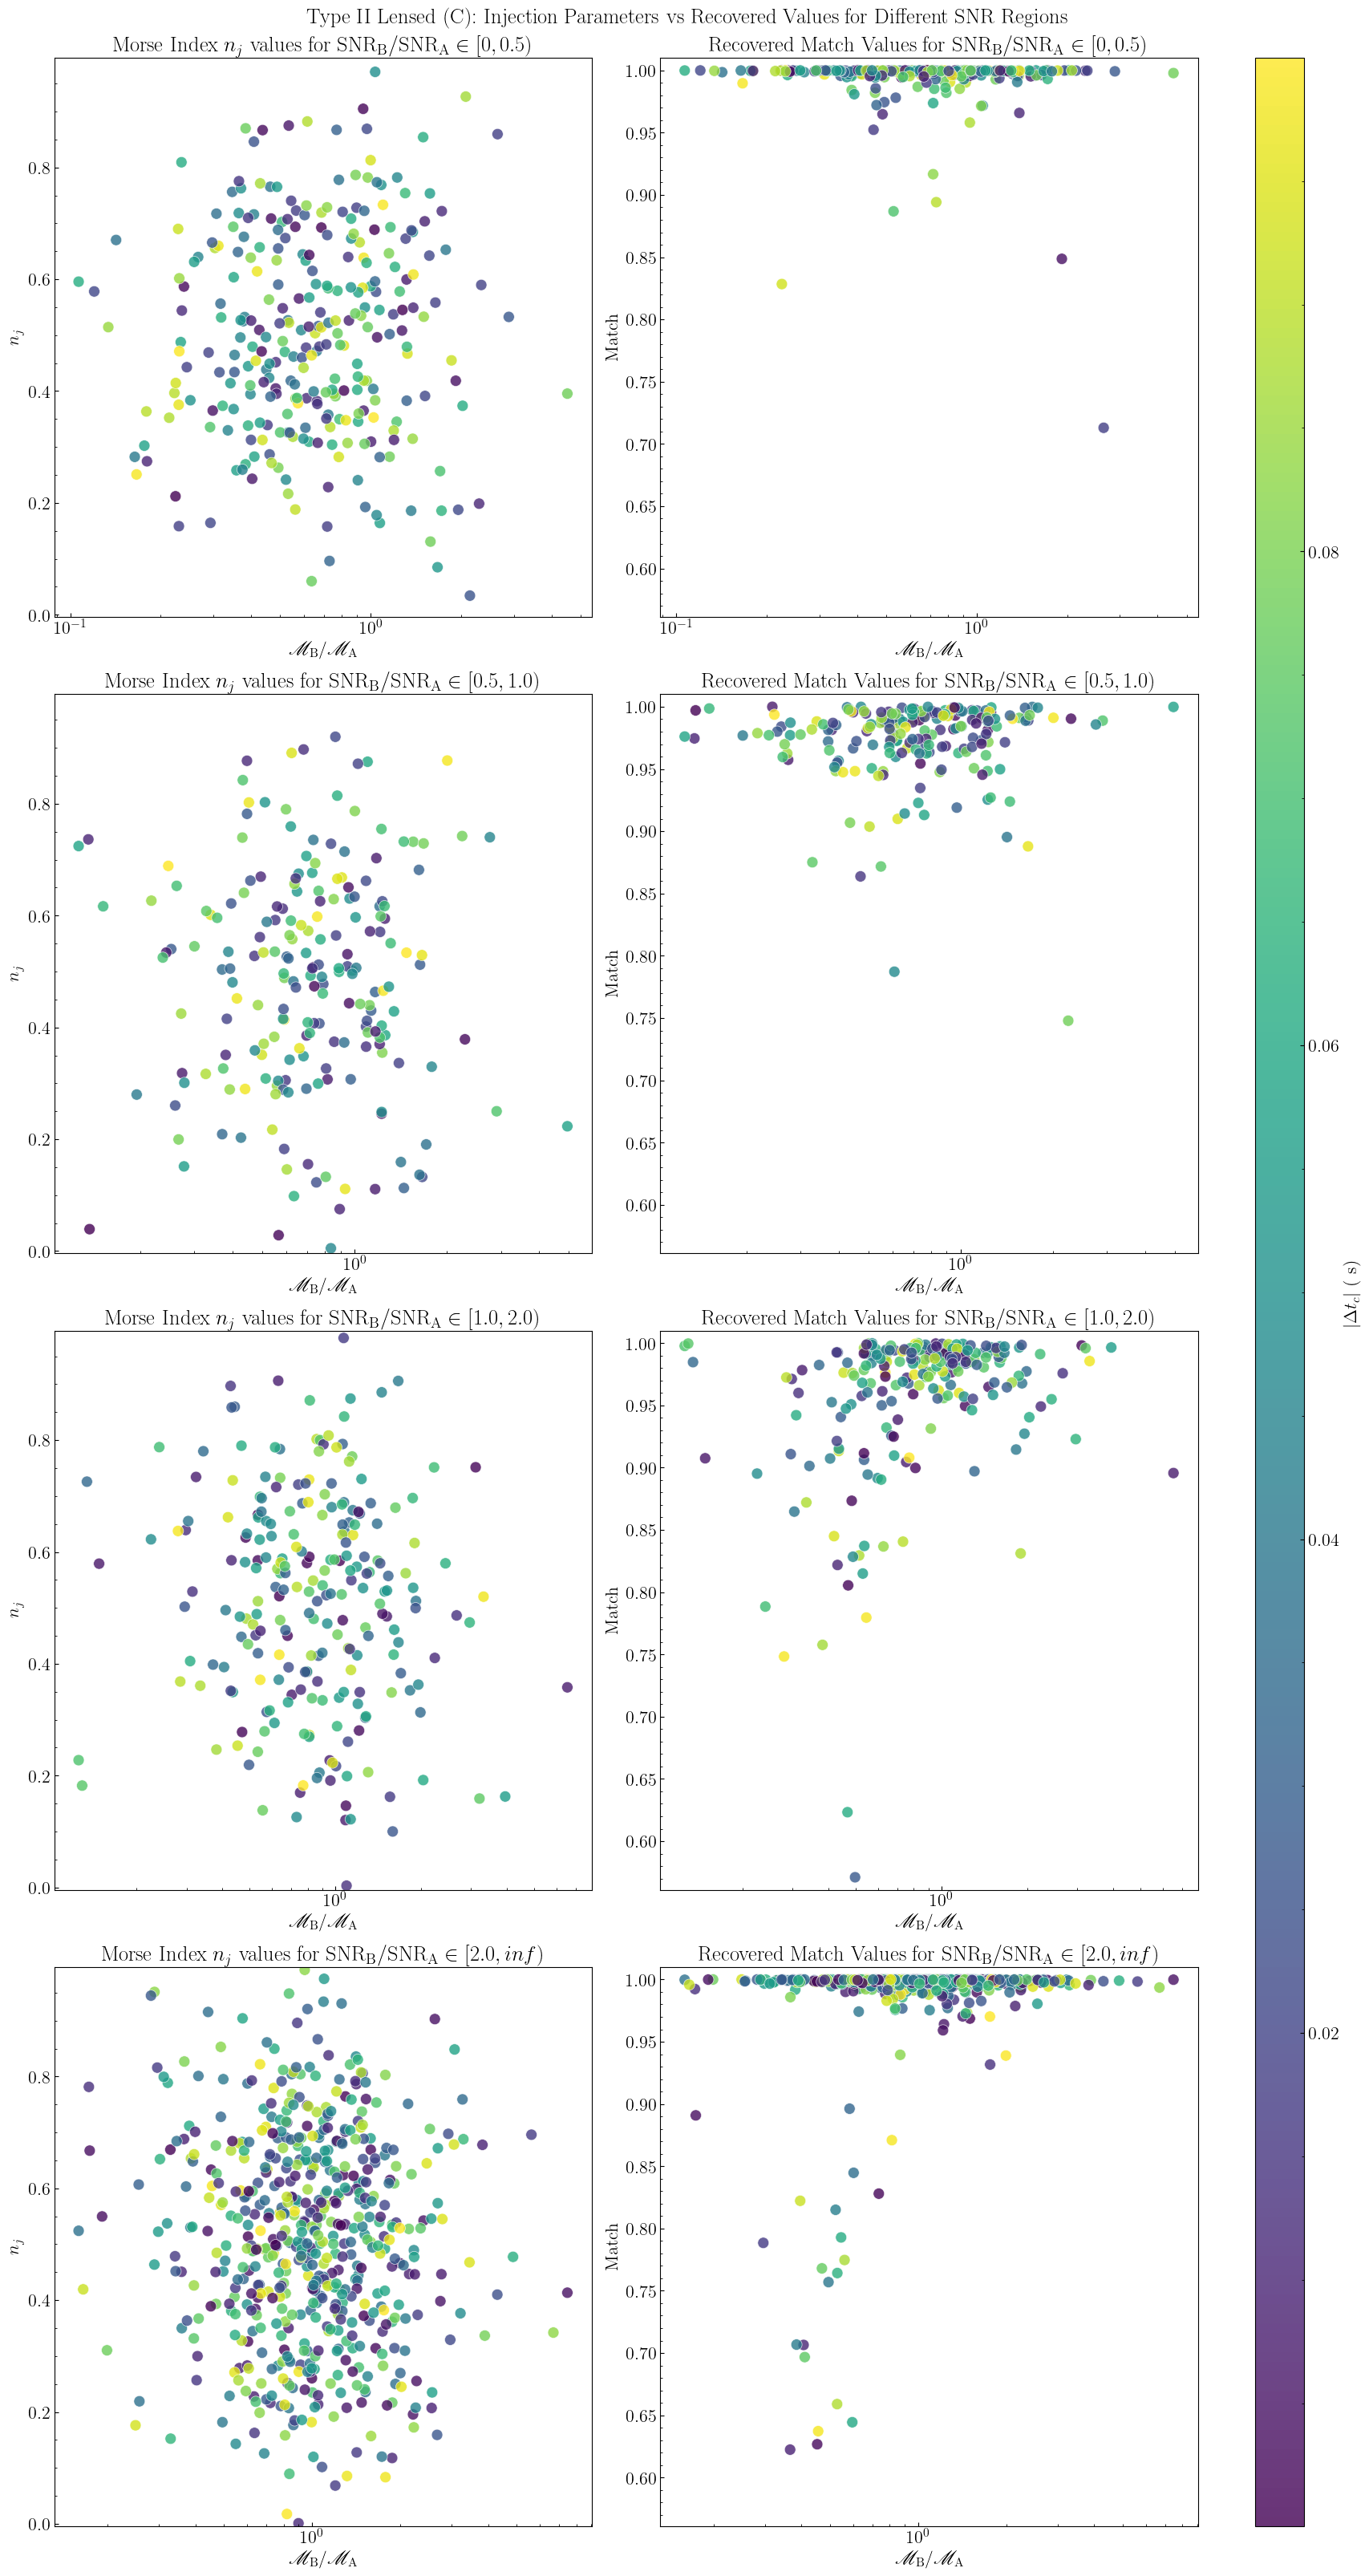

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(17, 32), constrained_layout=True)

for i, (snr_min, snr_max) in enumerate(snr_regions):
    mask = (snr_b / snr_a > snr_min) & (snr_b / snr_a <= snr_max)

    scatter1 = axes[i, 0].scatter(
        mchirp_b[mask] / mchirp_a[mask], n_ml2c[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 0].set_ylabel('$n_j$')
    axes[i, 0].set_title('Morse Index $n_j$ values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 0].set_ylim(np.min(n_ml2c)-0.005, np.max(n_ml2c)+0.005)

    scatter2 = axes[i, 1].scatter(
        mchirp_b[mask] / mchirp_a[mask], match_ml2c[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 1].set_ylabel('Match')
    axes[i, 1].set_title('Recovered Match Values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 1].set_ylim(np.min(match_ml2c)-0.01, np.max(match_ml2c)+0.01)

cbar = fig.colorbar(scatter2, ax=axes, location='right', aspect=50)
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
fig.suptitle('Type II Lensed (C): Injection Parameters vs Recovered Values for Different SNR Regions')
plt.show()

## Eccentric Recovery

In [21]:
match_ecc, mchirp_ecc, eta_ecc, e_ecc = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))
for i in range(len(indices)):
    try:
        data_H1 = np.load('../../output/pe_population/population/FF_ECC_3D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ecc_H1, mchirp_ecc_H1, eta_ecc_H1, e_ecc_H1 = data_H1[0], data_H1[1], data_H1[2], data_H1[3]
        data_L1 = np.load('../../output/pe_population/population/FF_ECC_3D_L1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ecc_L1, mchirp_ecc_L1, eta_ecc_L1, e_ecc_L1 = data_L1[0], data_L1[1], data_L1[2], data_L1[3]
        data_V1 = np.load('../../output/pe_population/population/FF_ECC_3D_V1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_ecc_V1, mchirp_ecc_V1, eta_ecc_V1, e_ecc_V1 = data_V1[0], data_V1[1], data_V1[2], data_V1[3]

        match_ecc[i] = np.sqrt(np.median([match_ecc_H1**2, match_ecc_L1**2, match_ecc_V1**2]))
        mchirp_ecc[i] = np.median([mchirp_ecc_H1, mchirp_ecc_L1, mchirp_ecc_V1])
        eta_ecc[i] = np.median([eta_ecc_H1, eta_ecc_L1, eta_ecc_V1])
        e_ecc[i] = np.median([e_ecc_H1, e_ecc_L1, e_ecc_V1])
    except:
        continue

match_ecc, mchirp_ecc, eta_ecc, e_ecc = match_ecc[match_ecc!=0], mchirp_ecc[match_ecc!=0], eta_ecc[match_ecc!=0], e_ecc[match_ecc!=0]

In [22]:
# match_ecc_0, mchirp_ecc_0, eta_ecc_0 = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))
# for i in range(len(indices)):
#     try:
#         data_H1 = np.load('../../output/pe_population/population/FF_ECC_0_2D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
#         match_ecc_0_H1, mchirp_ecc_0_H1, eta_ecc_0_H1 = data_H1[0], data_H1[1], data_H1[2]
#         data_L1 = np.load('../../output/pe_population/population/FF_ECC_0_2D_L1_{}.npy'.format(indices[i]), allow_pickle=True)
#         match_ecc_0_L1, mchirp_ecc_0_L1, eta_ecc_0_L1 = data_L1[0], data_L1[1], data_L1[2]
#         data_V1 = np.load('../../output/pe_population/population/FF_ECC_0_2D_V1_{}.npy'.format(indices[i]), allow_pickle=True)
#         match_ecc_0_V1, mchirp_ecc_0_V1, eta_ecc_0_V1 = data_V1[0], data_V1[1], data_V1[2]

#         match_ecc_0[i] = np.sqrt(np.median([match_ecc_0_H1**2, match_ecc_0_L1**2, match_ecc_0_V1**2]))
#         mchirp_ecc_0[i] = np.median([mchirp_ecc_0_H1, mchirp_ecc_0_L1, mchirp_ecc_0_V1])
#         eta_ecc_0[i] = np.median([eta_ecc_0_H1, eta_ecc_0_L1, eta_ecc_0_V1])
#     except:
#         data = np.load('../../output/pe_population/population/FF_ECC_0_2D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
#         match_ecc_0[i], mchirp_ecc_0[i], eta_ecc_0[i] = data[0], data[1], data[2]

In [23]:
# match_ecc, mchirp_ecc, eta_ecc, e_ecc = match_ecc[mask_0], mchirp_ecc[mask_0], eta_ecc[mask_0], e_ecc[mask_0]

In [24]:
# bias_mchirp_a_ecc = np.abs(mchirp_ecc-mchirp_a)/mchirp_a*100
# bias_mchirp_b_ecc = np.abs(mchirp_ecc-mchirp_b)/mchirp_b*100

In [25]:
# fig, axes = plt.subplots(1, 2, figsize=(17, 8), constrained_layout=True)

# 
# sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

# scatter1 = axes[0].scatter(mchirp_b/mchirp_a, e_ecc, c=np.abs(delta_tc),
#                         cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
#                         edgecolor='white', linewidth=0.5)
# axes[0].set_xscale('log')
# axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
# axes[0].set_ylabel('$e$')
# axes[0].set_title('Eccentricity $e$ values')

# axes[0].set_axisbelow(True)

# scatter2 = axes[1].scatter(mchirp_b/mchirp_a, match_ecc, c=np.abs(delta_tc),
#                         cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
#                         edgecolor='white', linewidth=0.5)
# axes[1].set_xscale('log')
# axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
# axes[1].set_ylabel('Match')
# axes[1].set_title('Recovered Match Values')

# axes[1].set_axisbelow(True)
# cbar = plt.colorbar(scatter2, ax=[axes[0], axes[1]])
# cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
# snr_markers = []
# for snr_val in [0.5, 1.0, 2.0]:
#     size = 200 * (snr_val / np.max(snr_b/snr_a))
#     snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
#                                  label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
# axes[1].legend(handles=snr_markers)

# fig.suptitle('Eccentric: Injection Parameters vs Recovered Values')
# plt.show()

In [26]:
# fig, axes = plt.subplots(4, 2, figsize=(17, 32), constrained_layout=True)

# for i, (snr_min, snr_max) in enumerate(snr_regions):
#     mask = (snr_b / snr_a > snr_min) & (snr_b / snr_a <= snr_max)

#     scatter1 = axes[i, 0].scatter(
#         mchirp_b[mask] / mchirp_a[mask], e_ecc[mask], c=np.abs(delta_tc[mask]), 
#         cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
#     )
#     axes[i, 0].set_xscale('log')
#     axes[i, 0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
#     axes[i, 0].set_ylabel('$e$')
#     axes[i, 0].set_title('Eccentricity $e$ values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
#     axes[i, 0].set_ylim(np.min(e_ecc)-0.005, np.max(e_ecc)+0.005)

#     scatter2 = axes[i, 1].scatter(
#         mchirp_b[mask] / mchirp_a[mask], match_ecc[mask], c=np.abs(delta_tc[mask]), 
#         cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
#     )
#     axes[i, 1].set_xscale('log')
#     axes[i, 1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
#     axes[i, 1].set_ylabel('Match')
#     axes[i, 1].set_title('Recovered Match Values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
#     axes[i, 1].set_ylim(np.min(match_ecc)-0.02, np.max(match_ecc)+0.02)

# cbar = fig.colorbar(scatter2, ax=axes, location='right', aspect=50)
# cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
# fig.suptitle('Eccentric: Injection Parameters vs Recovered Values for Different SNR Regions')
# plt.show()

## Singles Recovery

In [27]:
match, mchirp, eta = np.zeros(len(indices)), np.zeros(len(indices)), np.zeros(len(indices))
for i in range(len(indices)):
    try:
        data_H1 = np.load('../../output/pe_population/population/FF_2D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_H1, mchirp_H1, eta_H1 = data_H1[0], data_H1[1], data_H1[2]
        data_L1 = np.load('../../output/pe_population/population/FF_2D_L1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_L1, mchirp_L1, eta_L1 = data_L1[0], data_L1[1], data_L1[2]
        data_V1 = np.load('../../output/pe_population/population/FF_2D_V1_{}.npy'.format(indices[i]), allow_pickle=True)
        match_V1, mchirp_V1, eta_V1 = data_V1[0], data_V1[1], data_V1[2]

        match[i] = np.sqrt(np.median([match_H1**2, match_L1**2, match_V1**2]))
        mchirp[i] = np.median([mchirp_H1, mchirp_L1, mchirp_V1])
        eta[i] = np.median([eta_H1, eta_L1, eta_V1])
    except:
        data = np.load('../../output/pe_population/population/FF_2D_H1_{}.npy'.format(indices[i]), allow_pickle=True)
        match[i], mchirp[i], eta[i], = data[0], data[1], data[2]

In [28]:
match, mchirp, eta = match[mask_0], mchirp[mask_0], eta[mask_0]

In [29]:
bias_mchirp_a = np.abs(mchirp-mchirp_a)/mchirp_a*100
bias_mchirp_b = np.abs(mchirp-mchirp_b)/mchirp_b*100

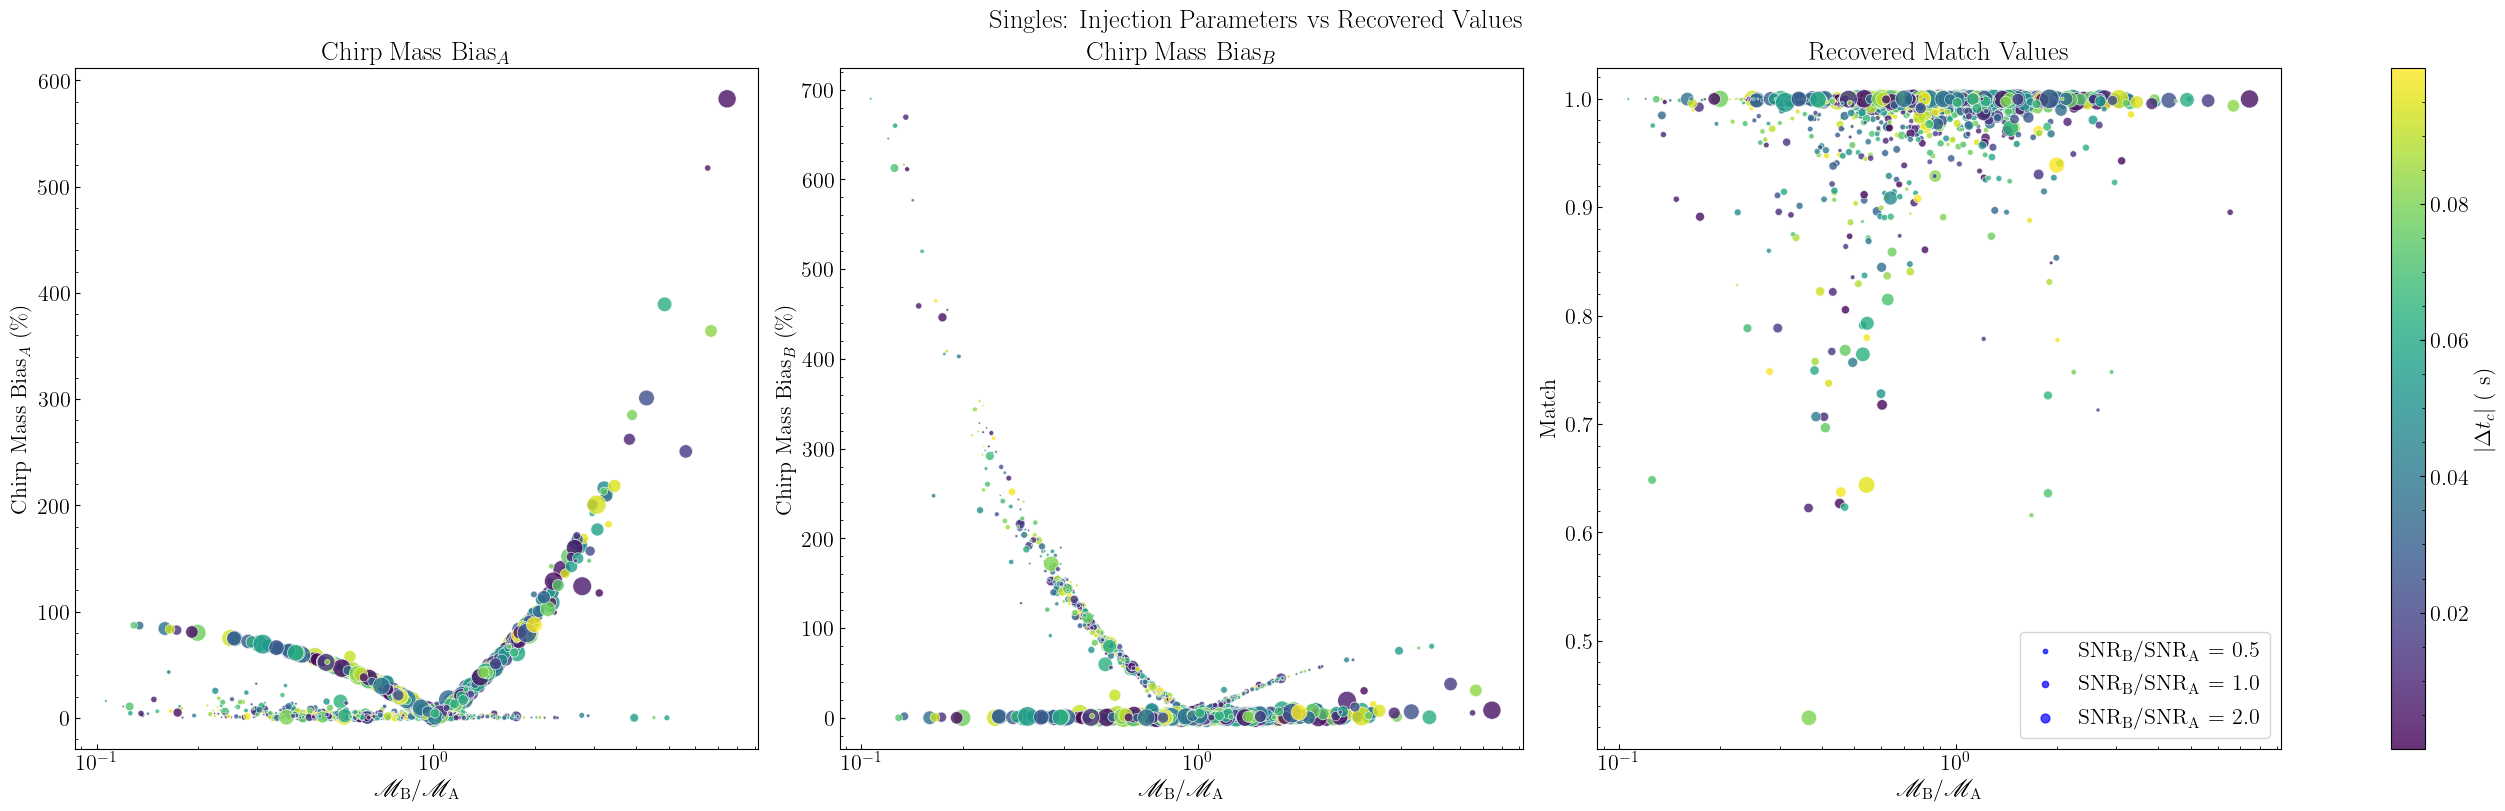

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)


sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

scatter1 = axes[0].scatter(mchirp_b/mchirp_a, bias_mchirp_a, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('Chirp Mass Bias$_A$ (\\%)')
axes[0].set_title('Chirp Mass Bias$_A$')

axes[0].set_axisbelow(True)

scatter2 = axes[1].scatter(mchirp_b/mchirp_a, bias_mchirp_b, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('Chirp Mass Bias$_B$ (\\%)')
axes[1].set_title('Chirp Mass Bias$_B$')

axes[1].set_axisbelow(True)

scatter3 = axes[2].scatter(mchirp_b/mchirp_a, match, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_ylabel('Match')
axes[2].set_title('Recovered Match Values')

axes[2].set_axisbelow(True)
cbar = plt.colorbar(scatter3, ax=[axes[0], axes[1], axes[2]])
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[2].legend(handles=snr_markers)

fig.suptitle('Singles: Injection Parameters vs Recovered Values')
plt.show()

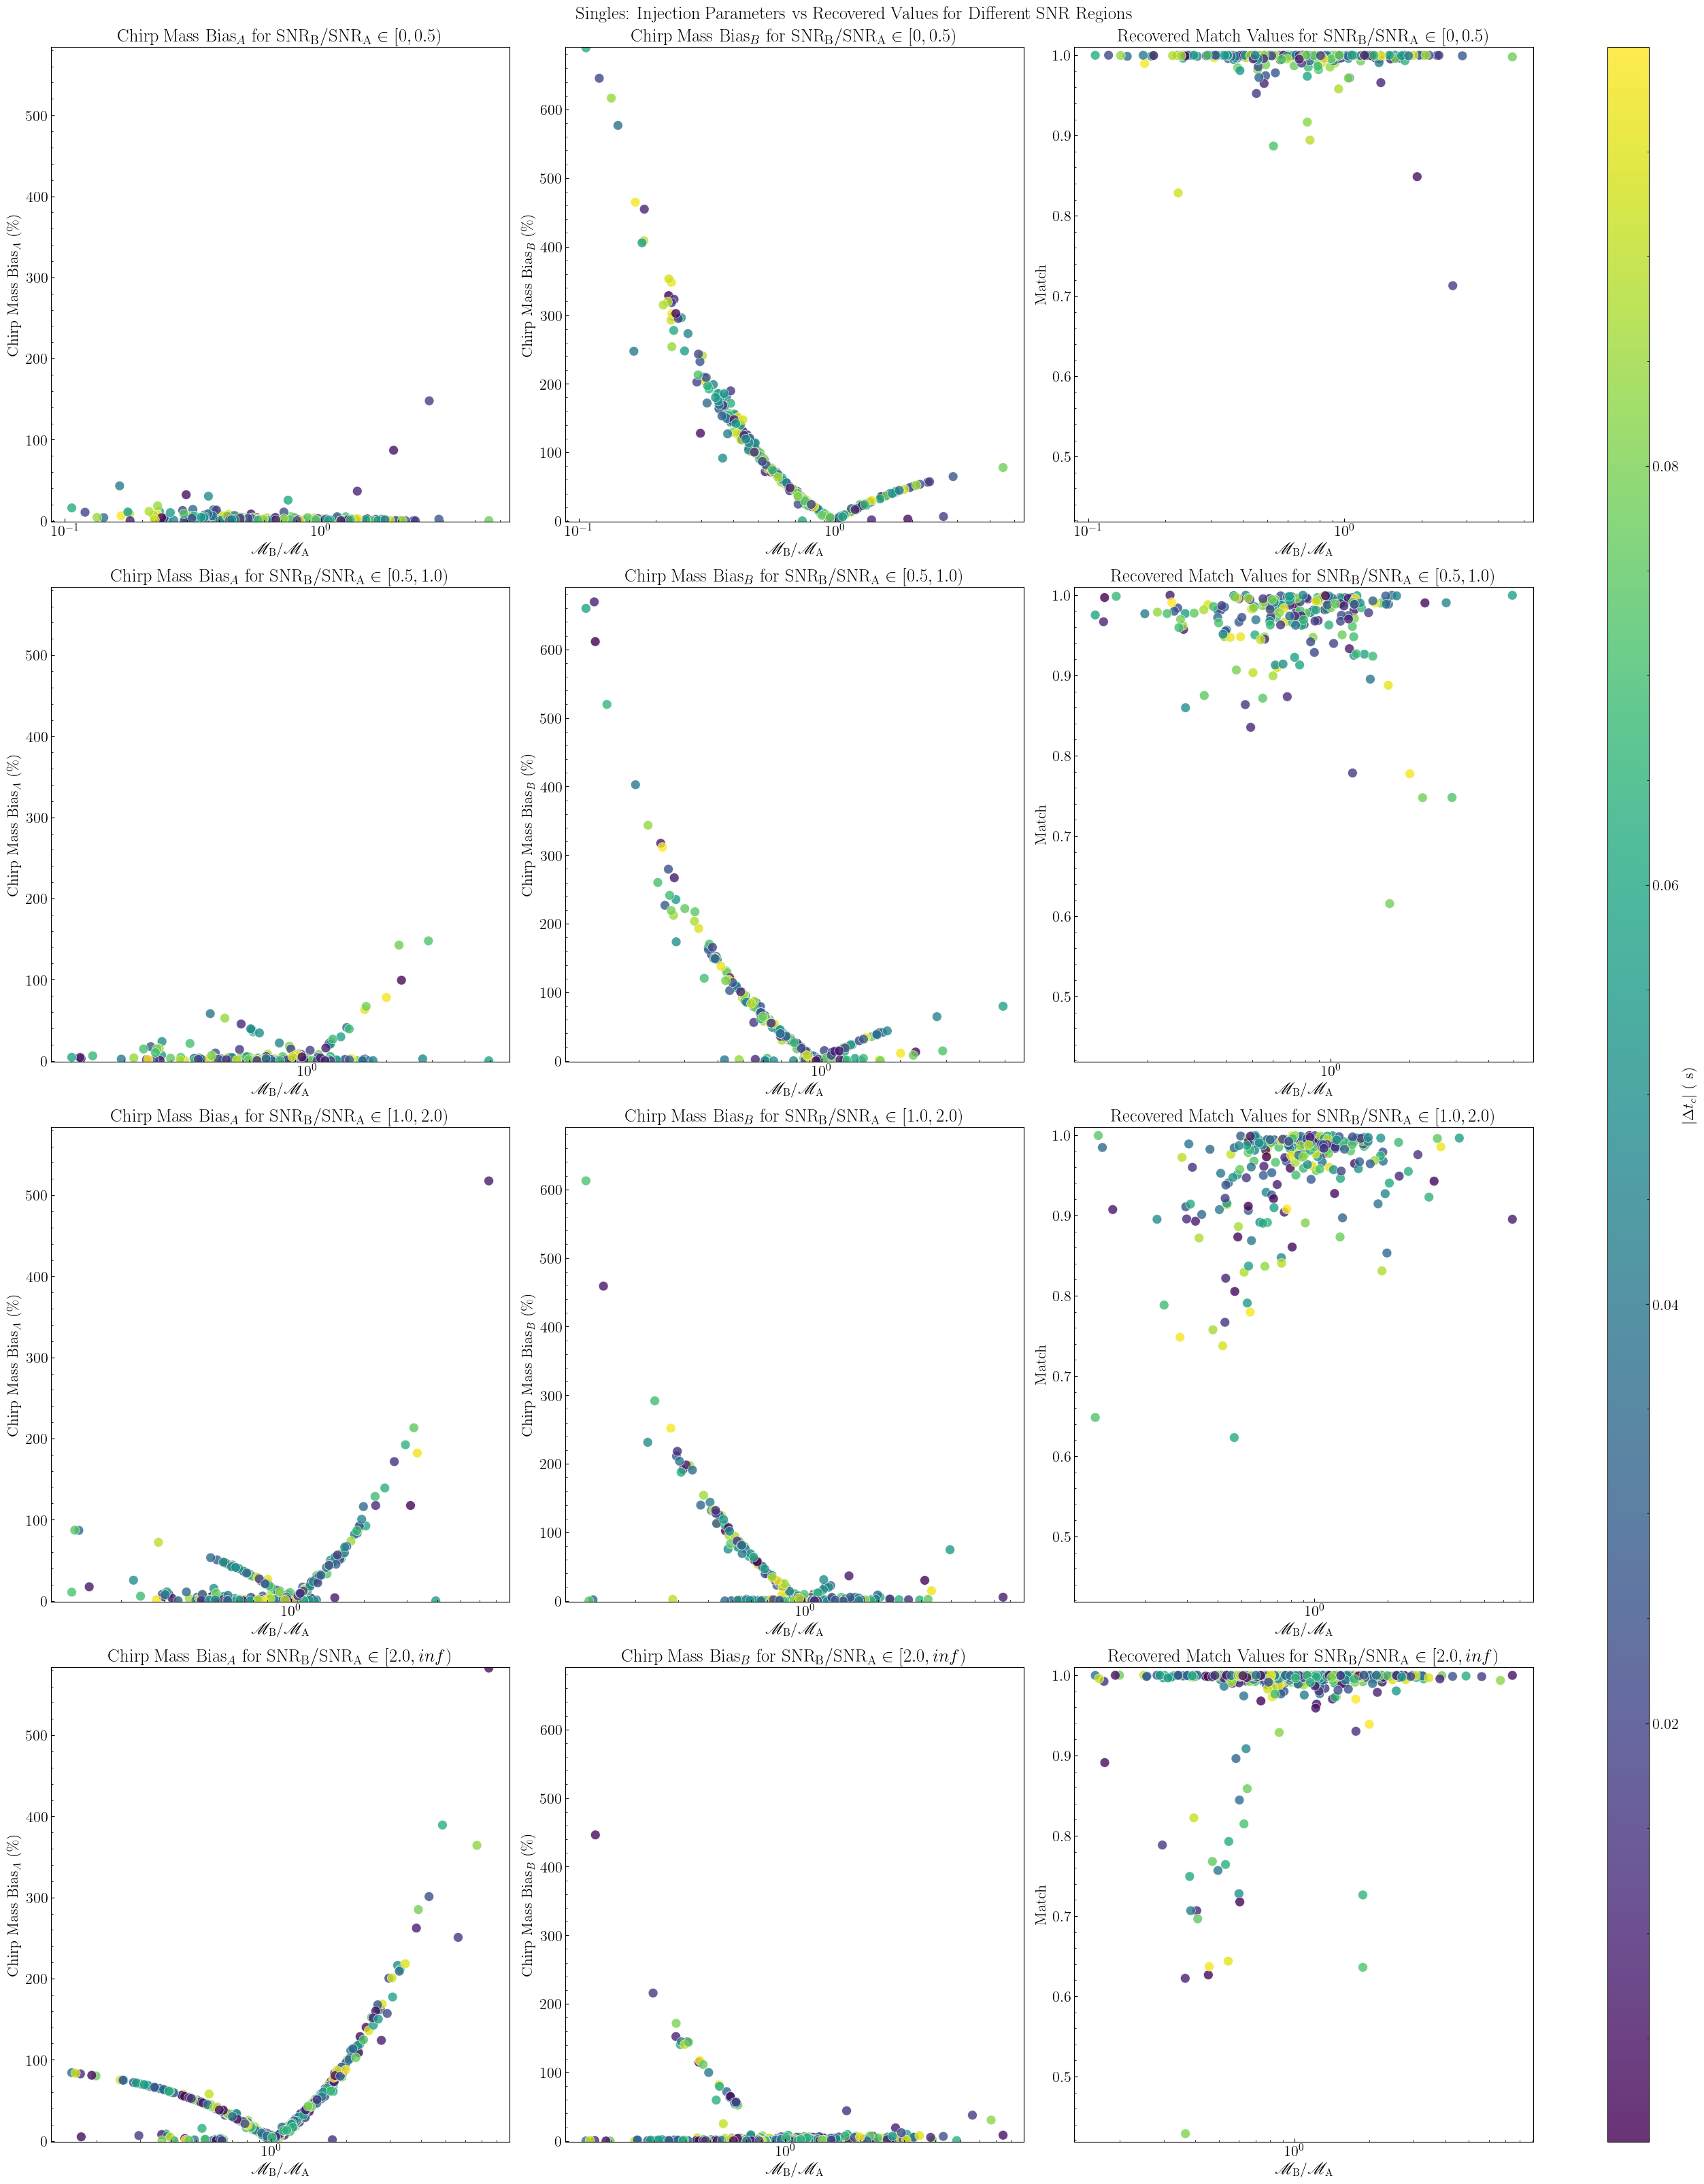

In [31]:
fig, axes = plt.subplots(4, 3, figsize=(25, 32), constrained_layout=True)
snr_regions = [(0, 0.5), (0.5, 1.0), (1.0, 2.0), (2.0, np.inf)]



for i, (snr_min, snr_max) in enumerate(snr_regions):
    mask = (snr_b / snr_a > snr_min) & (snr_b / snr_a <= snr_max)

    scatter1 = axes[i, 0].scatter(
        mchirp_b[mask] / mchirp_a[mask], bias_mchirp_a[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 0].set_ylabel('Chirp Mass Bias$_A$ (\\%)')
    axes[i, 0].set_title('Chirp Mass Bias$_A$ for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 0].set_ylim(np.min(bias_mchirp_a)-1, np.max(bias_mchirp_a)+1)

    scatter2 = axes[i, 1].scatter(
        mchirp_b[mask] / mchirp_a[mask], bias_mchirp_b[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 1].set_ylabel('Chirp Mass Bias$_B$ (\\%)')
    axes[i, 1].set_title('Chirp Mass Bias$_B$ for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 1].set_ylim(np.min(bias_mchirp_b)-1, np.max(bias_mchirp_b)+1)

    scatter3 = axes[i, 2].scatter(
        mchirp_b[mask] / mchirp_a[mask], match[mask], c=np.abs(delta_tc[mask]), 
        cmap=color_palette['colormap'], s=100, alpha=0.8, edgecolor='white', linewidth=0.5
    )
    axes[i, 2].set_xscale('log')
    axes[i, 2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
    axes[i, 2].set_ylabel('Match')
    axes[i, 2].set_title('Recovered Match Values for $\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}} \\in [{}, {})$'.format(snr_min, snr_max))
    
    axes[i, 2].set_ylim(np.min(match)-0.01, np.max(match)+0.01)

cbar = fig.colorbar(scatter3, ax=axes, location='right', aspect=50)
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')

fig.suptitle('Singles: Injection Parameters vs Recovered Values for Different SNR Regions')
plt.show()

### Comparisions

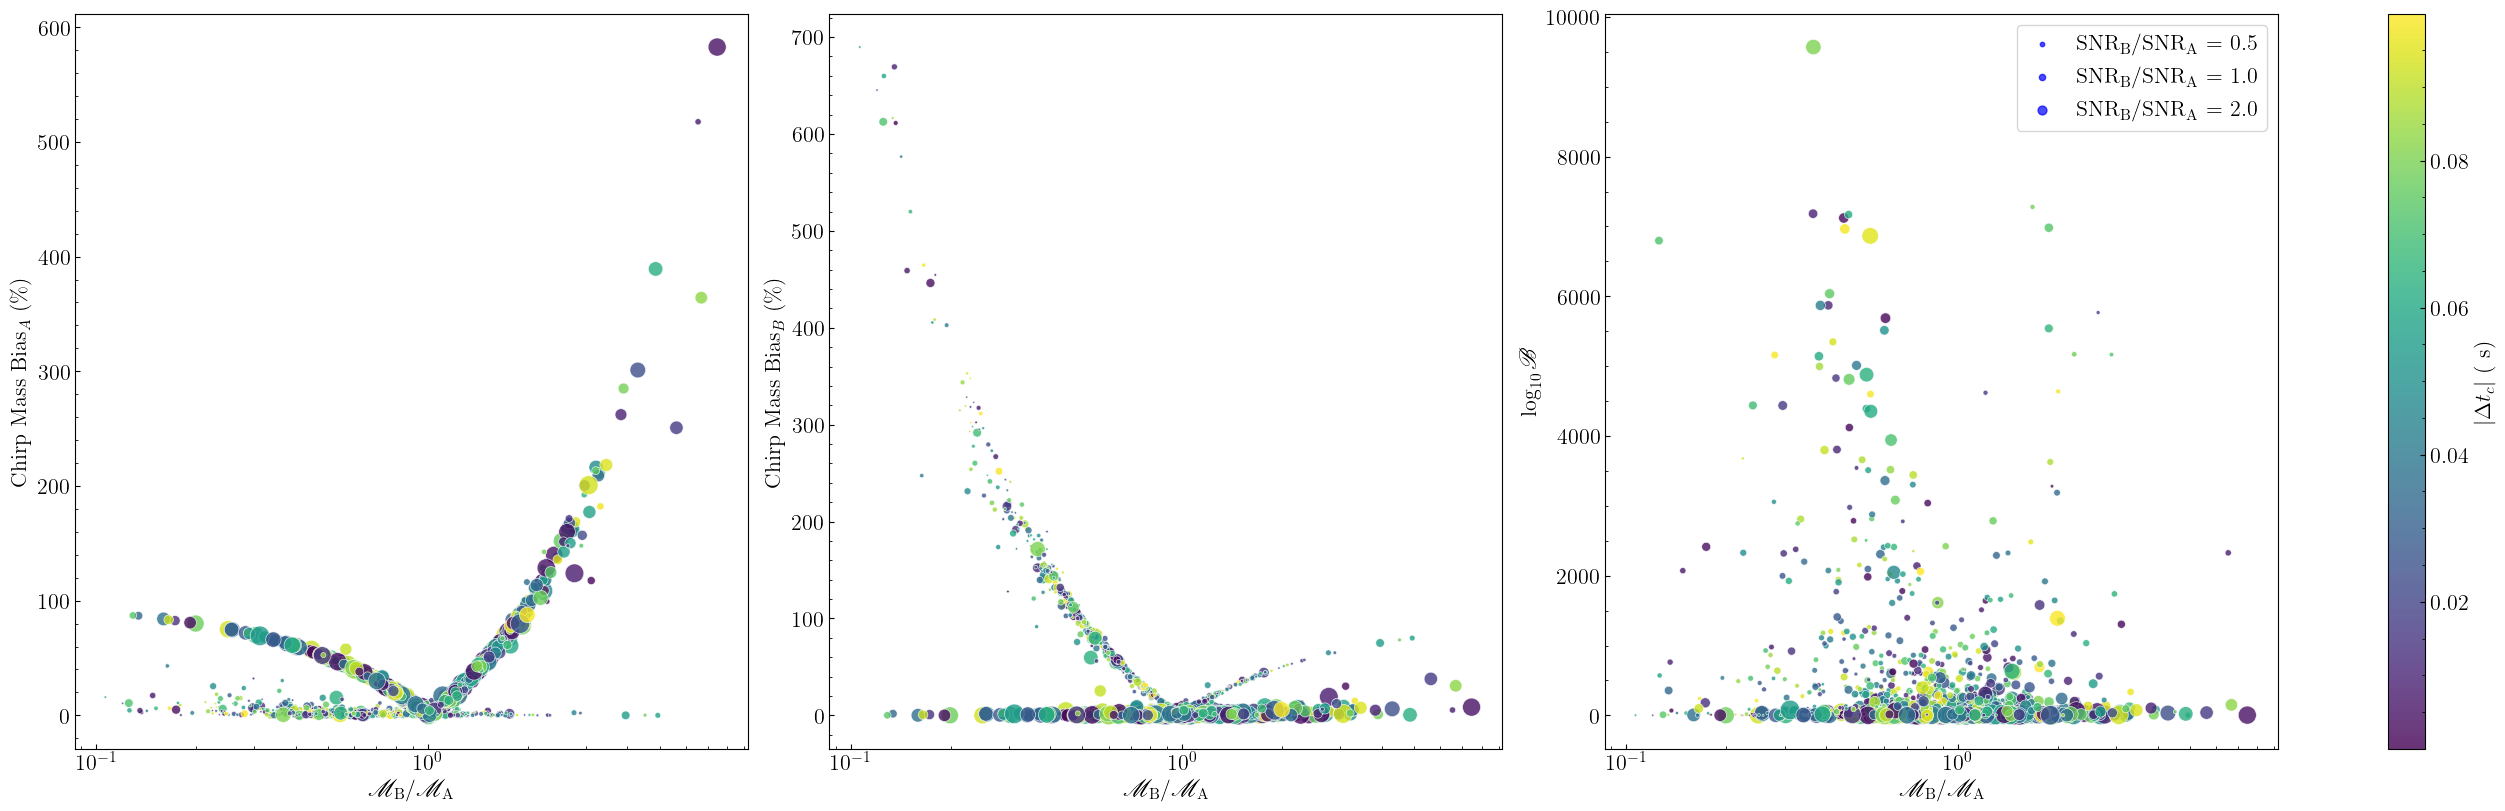

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)


sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

scatter1 = axes[0].scatter(mchirp_b/mchirp_a, bias_mchirp_a, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('Chirp Mass Bias$_A$ (\\%)')
#axes[0].set_title('Chirp Mass Bias$_A$')

axes[0].set_axisbelow(True)

scatter2 = axes[1].scatter(mchirp_b/mchirp_a, bias_mchirp_b, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('Chirp Mass Bias$_B$ (\\%)')
#axes[1].set_title('Chirp Mass Bias$_B$')

axes[1].set_axisbelow(True)

log_bayes_factor_0 = snr_a**2 *(1 - match**2)/np.log(10)*30

scatter3 = axes[2].scatter(mchirp_b/mchirp_a, log_bayes_factor_0, c=np.abs(delta_tc), 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_ylabel('$\\log_{10}\\mathscr{B}$')
#axes[2].set_title('Recovered $\\log_{10}\\mathscr{B}_0$ Values')

axes[2].set_axisbelow(True)
cbar = plt.colorbar(scatter3, ax=[axes[0], axes[1], axes[2]])
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[2].legend(handles=snr_markers)

plt.show()

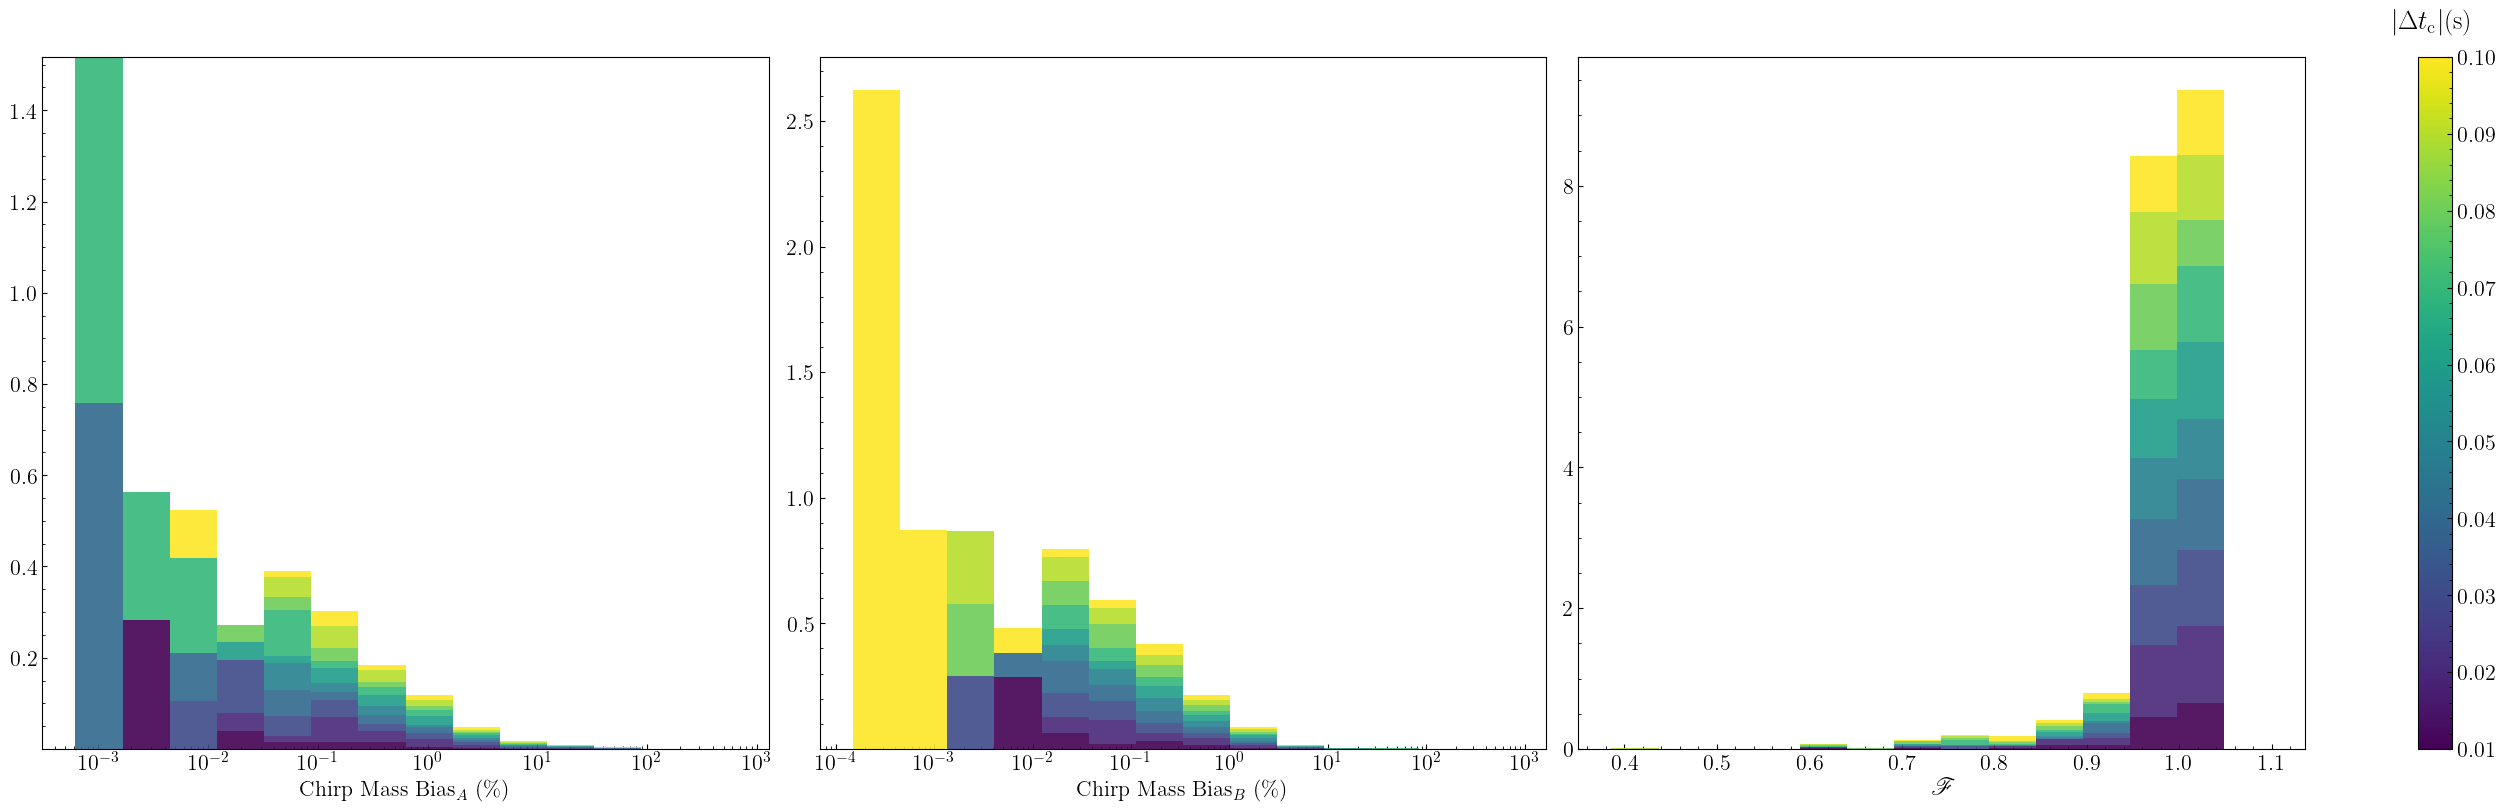

In [33]:
eps = 0.005
centers = np.arange(0.01, 0.101, 0.01)
edges = np.concatenate(([0.], centers - eps, [centers[-1] + eps]))

cmap = matplotlib.colormaps[color_palette['colormap']]
norm = matplotlib.colors.Normalize(vmin=centers[0], vmax=centers[-1])
colors = cmap(norm(centers))

def stacked_counts(x, delta_abs, mask, bins):
    hist_bins = bins
    counts_per_delta = []
    for i in range(len(centers)):
        sel = mask & (delta_abs >= edges[i]) & (delta_abs < edges[i+1])
        if np.any(sel):
            cts, _ = np.histogram(x[sel], bins=hist_bins)
        else:
            cts = np.zeros(len(hist_bins) - 1, dtype=int)
        counts_per_delta.append(cts)
    return np.array(counts_per_delta)

def bins(x, nbins=15, log_scale=True):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        raise ValueError("Input array has no finite values.")
    if log_scale:
        low = np.min(x) * 0.9
        high = np.max(x) * 1.1
        if low <= 0 or low == high:
            low = np.min(x[x>0]) * 0.9
            high = np.max(x) * 1.1
        return np.geomspace(low, high, nbins)
    else:
        lo = np.min(x) * 1.1 if np.min(x) < 0 else np.min(x) * 0.9
        hi = np.max(x) * 1.1 if np.max(x) > 0 else np.max(x) + 0.1
        if lo == hi:
            lo -= 0.5
            hi += 0.5
        return np.linspace(lo, hi, nbins)

x_list = [bias_mchirp_a, bias_mchirp_b, match]
x_labels = ['Chirp Mass Bias$_A$ (\\%)', 'Chirp Mass Bias$_B$ (\\%)', '$\\mathscr{F}$']
log_scales = [True, True, False]

full_mask = np.ones_like(np.asarray(delta_tc), dtype=bool)
delta_abs = np.abs(delta_tc)

fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)


for ax, x, xlabel, ls in zip(axes, x_list, x_labels, log_scales):
    xbins = bins(x, nbins=15, log_scale=ls)

    counts2d = stacked_counts(x, delta_abs, full_mask, xbins)
    counts2d = counts2d / (counts2d.sum() * (xbins[1:][None, :] - xbins[:-1][None, :]))
    bottom = np.zeros(xbins.size - 1)
    for j, cts in enumerate(counts2d):
        centers_x = (xbins[:-1] + xbins[1:]) / 2.0
        widths = (xbins[1:] - xbins[:-1])
        ax.bar(x=centers_x,
               height=cts,
               width=widths,
               bottom=bottom,
               align='center',
               color=colors[j],
               edgecolor='none',
               alpha=0.9)
        bottom = bottom + cts

    if ls:
        ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_axisbelow(True)

sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right')
cbar.ax.set_title('$|\\Delta t_{\\rm c}| ({\\rm s})$', pad=20)

plt.show()

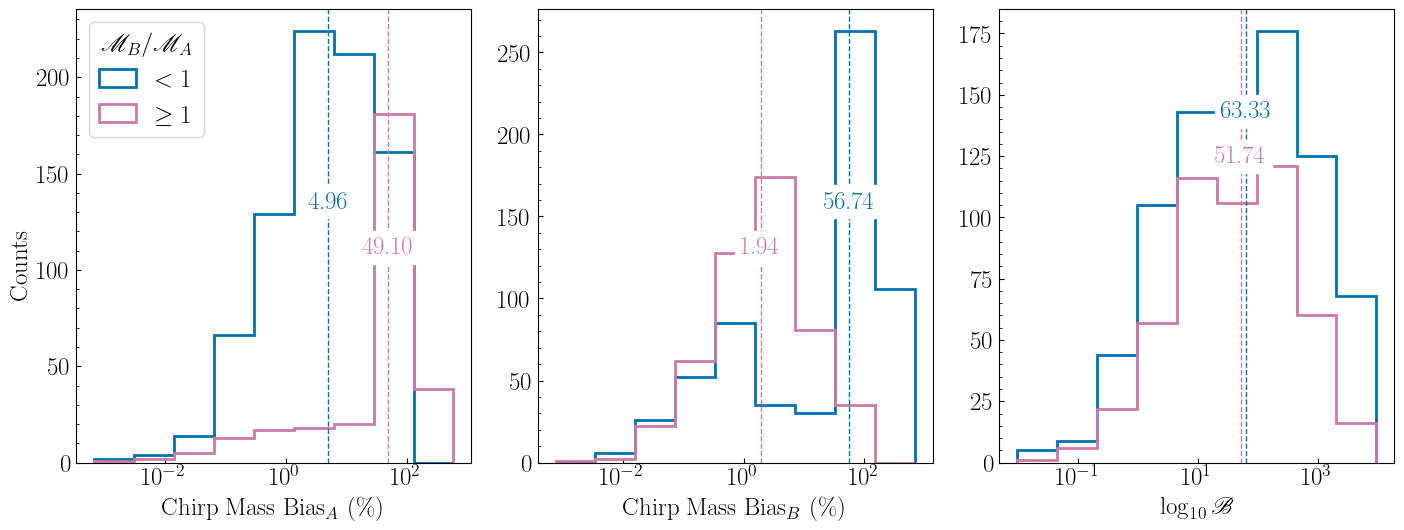

In [34]:
plt.rcParams.update(new_rcParams(width='page'))
fig, axs = plt.subplots(1, 3)

ax = axs[0]
bias_mchirp_a_l = bias_mchirp_a[mchirp_b / mchirp_a < 1]
bias_mchirp_a_u = bias_mchirp_a[mchirp_b / mchirp_a > 1.25]

all_samples = np.hstack([
    bias_mchirp_a_l[~np.isnan(bias_mchirp_a_l)],
    bias_mchirp_a_u[~np.isnan(bias_mchirp_a_u)]
])
bins = np.geomspace(np.nanmin(all_samples), np.nanmax(all_samples), 10)

ax.hist(bias_mchirp_a_l, bins=bins, histtype='step', linewidth=2,
        label=r'$< 1$', color=color_palette['primary'])
ax.hist(bias_mchirp_a_u, bins=bins, histtype='step', linewidth=2,
        label=r'$\geq 1$', color=color_palette['secondary'])

vmed = np.nanmedian(bias_mchirp_a_l)
vmap = np.nanmedian(bias_mchirp_a_u)
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.axvline(vmap, color=color_palette['secondary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1] * 0.6, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')
ax.text(vmap, ax.get_ylim()[1] * 0.5, f'{vmap:.2f}', color=color_palette['secondary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xscale('log')
ax.set_xlabel(r'Chirp Mass Bias$_A$ (\%)')
ax.legend(title=r'$\mathscr{M}_B/\mathscr{M}_A$')
ax.grid(False)

ax = axs[1]
bias_mchirp_b_l = bias_mchirp_b[mchirp_b / mchirp_a < 1 / 1.25]
bias_mchirp_b_u = bias_mchirp_b[mchirp_b / mchirp_a > 1]

all_samples = np.hstack([
    bias_mchirp_b_l[~np.isnan(bias_mchirp_b_l)],
    bias_mchirp_b_u[~np.isnan(bias_mchirp_b_u)]
])
bins = np.geomspace(np.nanmin(all_samples), np.nanmax(all_samples), 10)

ax.hist(bias_mchirp_b_l, bins=bins, histtype='step', linewidth=2,
        label=r'< 1$', color=color_palette['primary'])
ax.hist(bias_mchirp_b_u, bins=bins, histtype='step', linewidth=2,
        label=r'$\geq 1$', color=color_palette['secondary'])

vmed = np.nanmedian(bias_mchirp_b_l)
vmap = np.nanmedian(bias_mchirp_b_u)
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.axvline(vmap, color=color_palette['secondary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1] * 0.6, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')
ax.text(vmap, ax.get_ylim()[1] * 0.5, f'{vmap:.2f}', color=color_palette['secondary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xscale('log')
ax.set_xlabel(r'Chirp Mass Bias$_B$ (\%)')
ax.grid(False)

ax = axs[2]
log_bayes_factor_0_l = log_bayes_factor_0[mchirp_b / mchirp_a < 1]
log_bayes_factor_0_u = log_bayes_factor_0[mchirp_b / mchirp_a > 1]

all_samples = np.hstack([
    log_bayes_factor_0_l[~np.isnan(log_bayes_factor_0_l)],
    log_bayes_factor_0_u[~np.isnan(log_bayes_factor_0_u)]
])

bins = np.geomspace(np.nanmin(all_samples), np.nanmax(all_samples), 10)

ax.hist(log_bayes_factor_0_l, bins=bins, histtype='step', linewidth=2,
        label=r'$< 1$', color=color_palette['primary'])
ax.hist(log_bayes_factor_0_u, bins=bins, histtype='step', linewidth=2,
        label=r'$\geq 1$', color=color_palette['secondary'])

vmed = np.nanmedian(log_bayes_factor_0_l)
vmap = np.nanmedian(log_bayes_factor_0_u)
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.axvline(vmap, color=color_palette['secondary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1] * 0.8, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')
ax.text(vmap, ax.get_ylim()[1] * 0.7, f'{vmap:.2f}', color=color_palette['secondary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xscale('log')
ax.set_xlabel(r'$\log_{10}\mathscr{B}$')
ax.grid(False)

fig.text(0, 0.5, 'Counts', va='center', rotation='vertical', fontsize=plt.rcParams.get('axes.labelsize', 10))

plt.tight_layout()
plt.savefig('../../output/pe_population/output/SinglesFFPopulation.pdf')
plt.show()

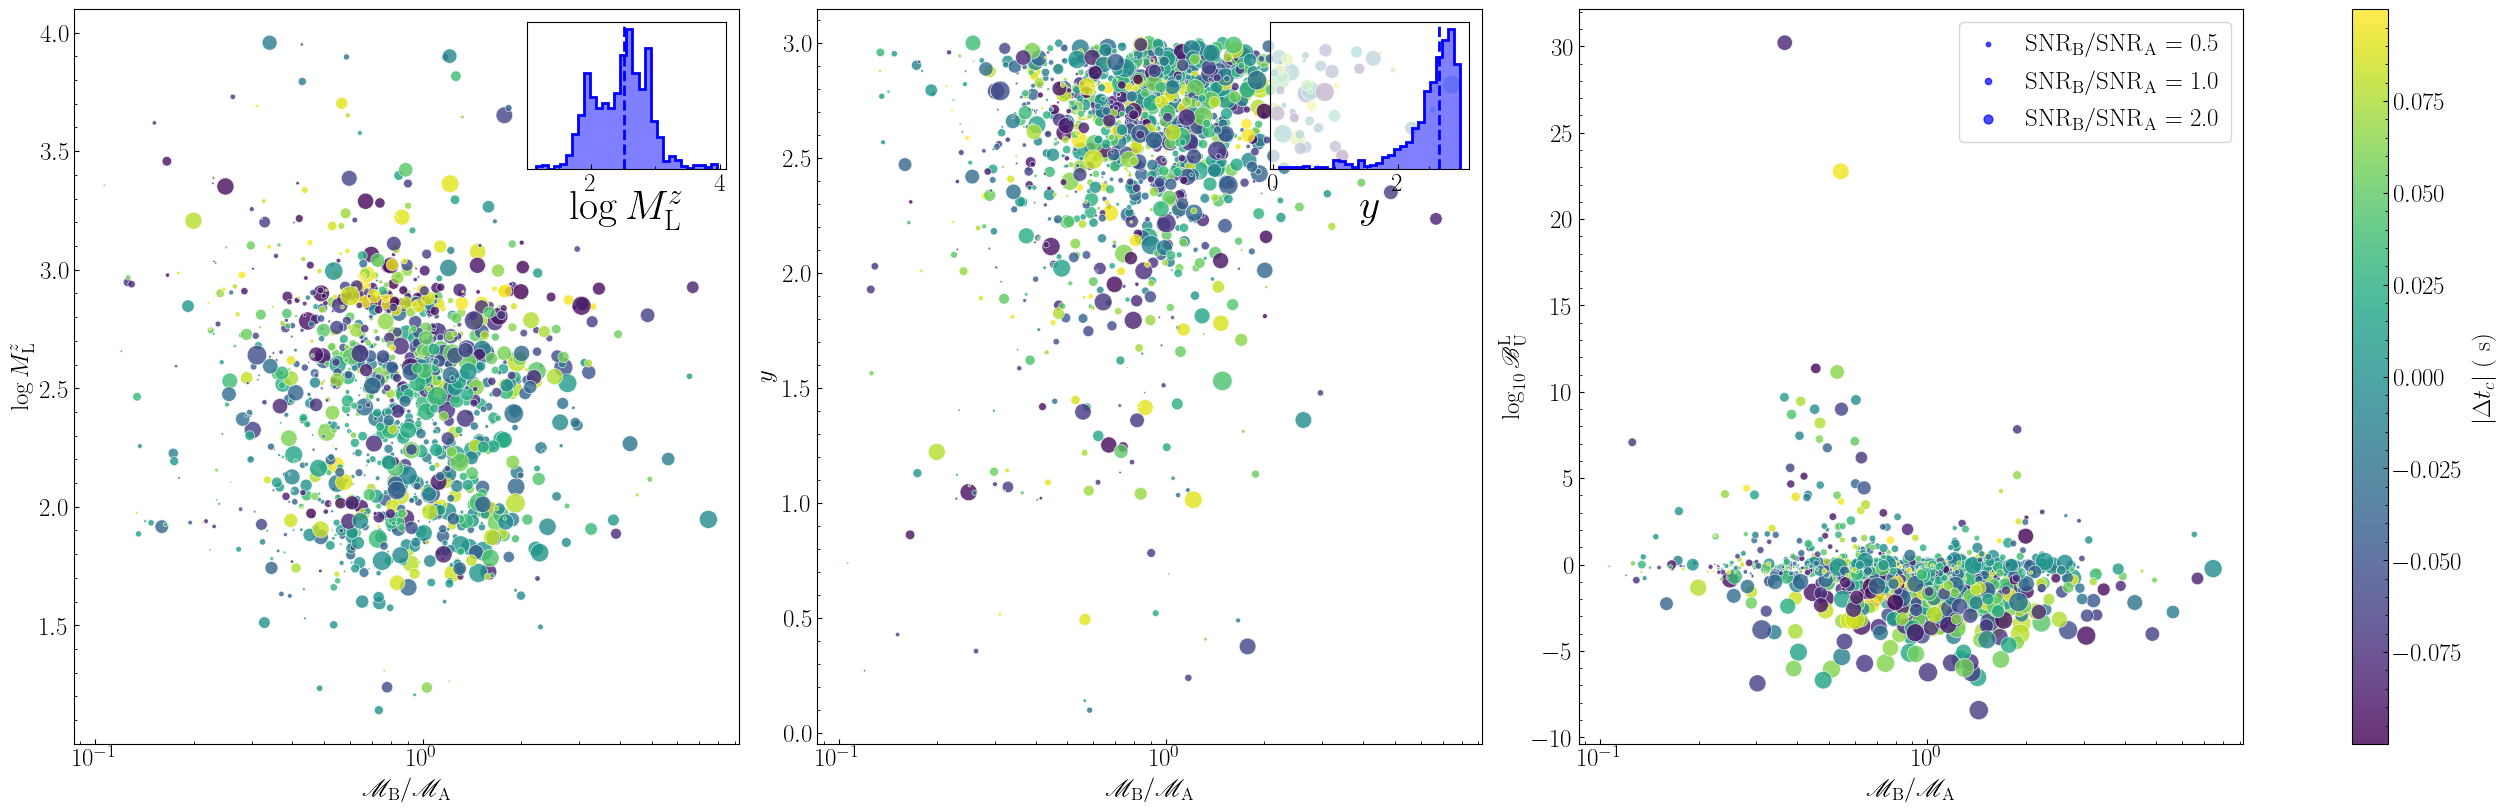

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)

sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

scatter1 = axes[0].scatter(mchirp_b/mchirp_a, np.log10(Ml_z_ml), c=delta_tc, 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('$\\log M_{\\rm L}^z$')
#axes[0].set_title('Redshifted Lens Mass $M_{\\rm L}^z$ values')

axes[0].set_axisbelow(True)

scatter2 = axes[1].scatter(mchirp_b/mchirp_a, y_ml, c=delta_tc, 
                      cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                      edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('$y$')
#axes[1].set_title('Impact Parameter $y$ values')

axes[1].set_axisbelow(True)

log_bayes_factor_ml_diff = np.sqrt(snr_a**2+snr_b**2)*(match_ml**2-match**2)/2/np.log(10)

scatter3 = axes[2].scatter(mchirp_b/mchirp_a, log_bayes_factor_ml_diff, c=delta_tc,
                        cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                        edgecolor='white', linewidth=0.5)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_ylabel('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')
#axes[2].set_title('Estimated $\\log_{10}\\mathscr{B}_{{ML}}-\\log_{10}\\mathscr{B}_0$ Values')

axes[2].set_axisbelow(True)

cbar = plt.colorbar(scatter3, ax=[axes[0], axes[1], axes[2]])
cbar.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[2].legend(handles=snr_markers)

ax_inset1 = inset_axes(axes[0], width="30%", height="20%", loc='upper right', 
                      bbox_to_anchor=(0, 0, 1, 1), bbox_transform=axes[0].transAxes)
ax_inset1.patch.set_alpha(0.7)
ax_inset1.hist(np.log10(Ml_z_ml), bins=30, histtype='step', lw=2, color='blue', density=True)
ax_inset1.hist(np.log10(Ml_z_ml), bins=30, histtype='stepfilled', alpha=0.5, color='blue', density=True)
ax_inset1.axvline(np.median(np.log10(Ml_z_ml)), color='blue', linestyle='--', lw=2)
ax_inset1.set_yticks([])
ax_inset1.set_xlabel('$\\log M_{\\rm L}^z$', fontsize=30, labelpad=-5)

ax_inset2 = inset_axes(axes[1], width="30%", height="20%", loc='upper right', 
                      bbox_to_anchor=(0, 0, 1, 1), bbox_transform=axes[1].transAxes)
ax_inset2.patch.set_alpha(0.7)
ax_inset2.hist(y_ml, bins=30, histtype='step', lw=2, color='blue', density=True)
ax_inset2.hist(y_ml, bins=30, histtype='stepfilled', alpha=0.5, color='blue', density=True)
ax_inset2.axvline(np.median(y_ml), color='blue', linestyle='--', lw=2)
ax_inset2.set_yticks([])
ax_inset2.set_xlabel('$y$', fontsize=30, labelpad=-5)

plt.show()

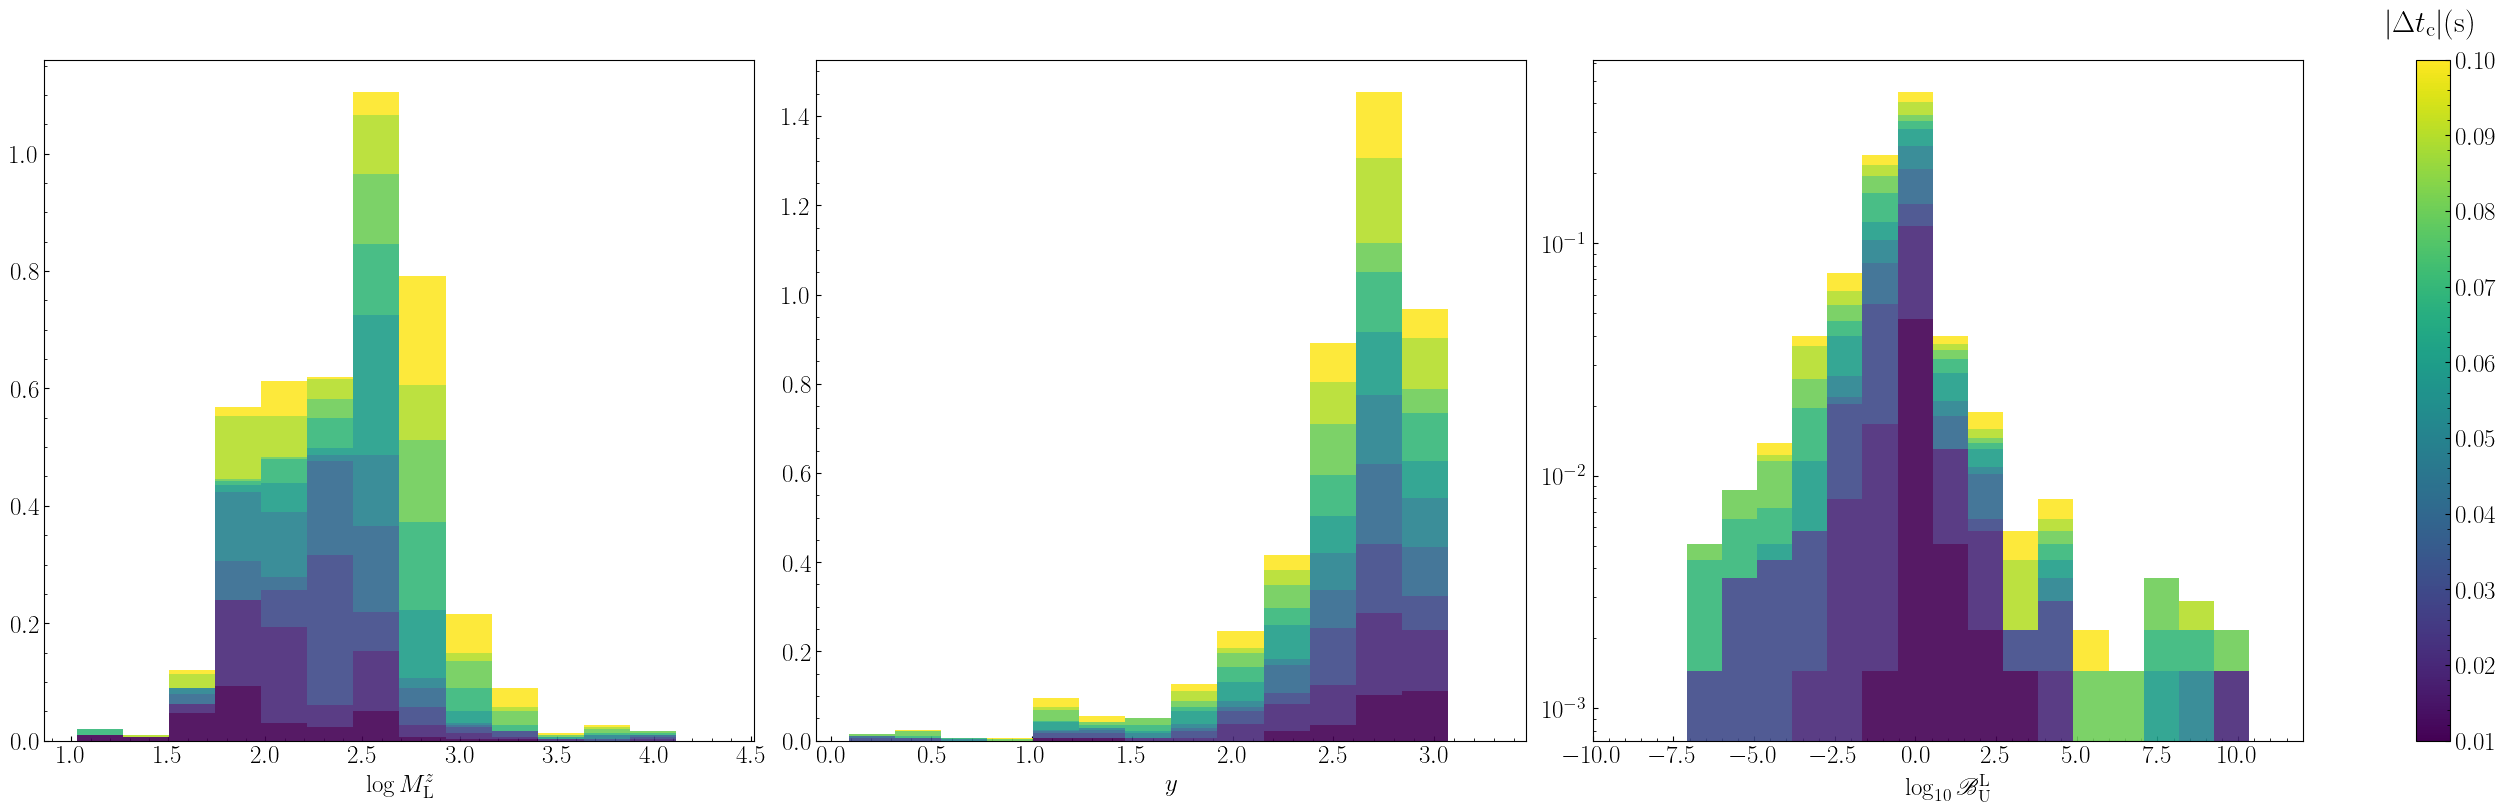

In [36]:
eps = 0.005
centers = np.arange(0.01, 0.101, 0.01)
edges = np.concatenate(([0.], centers - eps, [centers[-1] + eps]))

cmap = matplotlib.colormaps[color_palette['colormap']]
norm = matplotlib.colors.Normalize(vmin=centers[0], vmax=centers[-1])
colors = cmap(norm(centers))

def stacked_counts(x, delta_abs, mask, bins):
    hist_bins = bins
    counts_per_delta = []
    for i in range(len(centers)):
        sel = mask & (delta_abs >= edges[i]) & (delta_abs < edges[i+1])
        if np.any(sel):
            cts, _ = np.histogram(x[sel], bins=hist_bins)
        else:
            cts = np.zeros(len(hist_bins) - 1, dtype=int)
        counts_per_delta.append(cts)
    return np.array(counts_per_delta)

def bins(x, nbins=15, log_scale=True):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if log_scale:
        low = np.min(x) * 0.9
        high = np.max(x) * 1.1
        if low <= 0 or low == high:
            low = np.min(x[x>0]) * 0.9
            high = np.max(x) * 1.1
        return np.geomspace(low, high, nbins)
    else:
        lo = np.min(x) * 1.1 if np.min(x) < 0 else np.min(x) * 0.9
        hi = np.max(x) * 1.1 if np.max(x) > 0 else np.max(x) + 0.1
        if lo == hi:
            lo -= 0.5
            hi += 0.5
        return np.linspace(lo, hi, nbins)

x_list = [np.log10(Ml_z_ml), y_ml, log_bayes_factor_ml_diff]
x_labels = ['$\\log M_{\\rm L}^z$', '$y$', '$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$']
log_scales = [False, False, False]

full_mask = np.ones_like(np.asarray(delta_tc), dtype=bool)
delta_abs = np.abs(delta_tc)

fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)

for ax, x, xlabel, ls in zip(axes, x_list, x_labels, log_scales):
    if x in log_bayes_factor_ml_diff:
        xbins = bins(x, nbins=40, log_scale=ls)
    else:
        xbins = bins(x, nbins=15, log_scale=ls)

    counts2d = stacked_counts(x, delta_abs, full_mask, xbins)
    counts2d = counts2d / (counts2d.sum() * (xbins[1:][None, :] - xbins[:-1][None, :]))
    bottom = np.zeros(xbins.size - 1)
    for j, cts in enumerate(counts2d):
        centers_x = (xbins[:-1] + xbins[1:]) / 2.0
        widths = (xbins[1:] - xbins[:-1])
        ax.bar(x=centers_x,
               height=cts,
               width=widths,
               bottom=bottom,
               align='center',
               color=colors[j],
               edgecolor='none',
               alpha=0.9)
        bottom = bottom + cts

    if ls:
        ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_axisbelow(True)

axes[2].set_yscale('log')
axes[2].set_xlim(-10, 12)

sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right')
cbar.ax.set_title('$|\\Delta t_{\\rm c}| ({\\rm s})$', pad=20)

plt.show()

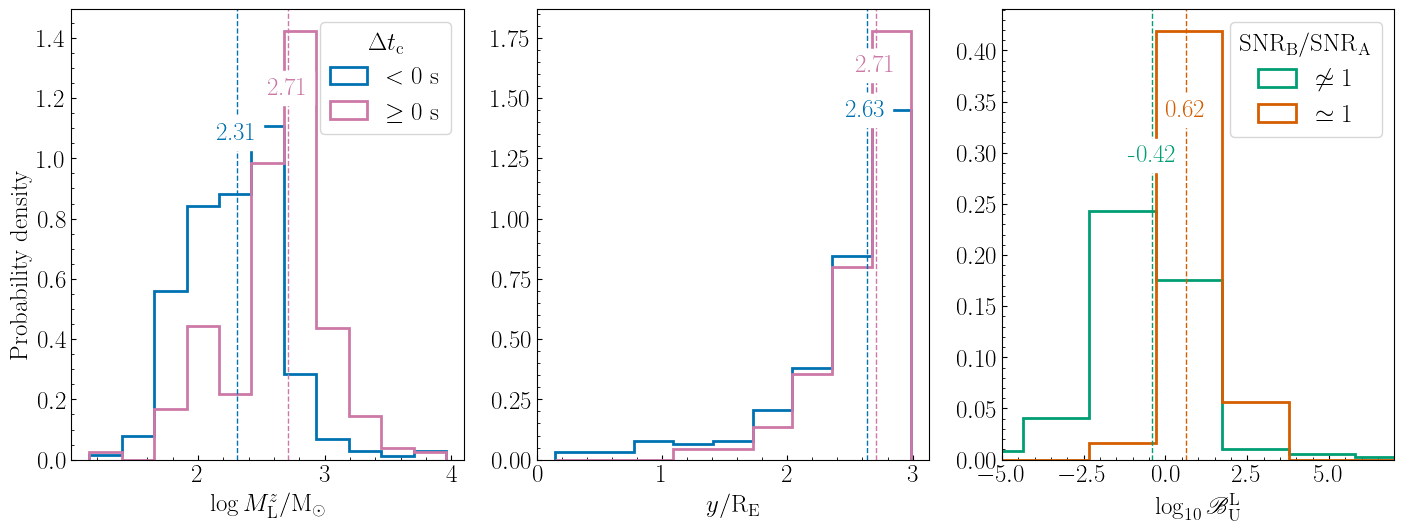

In [37]:
fig, axs = plt.subplots(1, 3)
ax = axs[0]

Ml_z_ml_l = Ml_z_ml[abs(delta_tc) < 0.05]
Ml_z_ml_u = Ml_z_ml[abs(delta_tc) > 0.05]

all_samples = np.hstack([Ml_z_ml_l[~np.isnan(Ml_z_ml_l)], Ml_z_ml_u[~np.isnan(Ml_z_ml_u)]])
bins = np.linspace(np.nanmin(np.log10(all_samples)), np.nanmax(np.log10(all_samples)), 12)

ax.hist(np.log10(Ml_z_ml_l), bins=bins, density=True,
        histtype='step', linewidth=2, label='$< 0~\\mathrm{s}$', color=color_palette['primary'])
ax.hist(np.log10(Ml_z_ml_u), bins=bins, density=True,
        histtype='step', linewidth=2, label='$\\geq 0~\\mathrm{s}$', color=color_palette['secondary'])

vmed = np.nanmedian(np.log10(Ml_z_ml_l))
vmap = np.nanmedian(np.log10(Ml_z_ml_u))
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.axvline(vmap, color=color_palette['secondary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1]*0.75, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')
ax.text(vmap, ax.get_ylim()[1]*0.85, f'{vmap:.2f}', color=color_palette['secondary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xlabel(r'$\log M_{\rm L}^z/{\rm M}_\odot$')
ax.legend(title=r'$\Delta t_{\rm c}$')
ax.grid(False)

ax = axs[1]

y_ml_l = y_ml[snr_b/snr_a < 0.5]
y_ml_u = y_ml[mchirp_b/mchirp_a > 2]

all_samples = np.hstack([y_ml_l[~np.isnan(y_ml_l)], y_ml_u[~np.isnan(y_ml_u)]])
bins = np.linspace(np.nanmin(all_samples), np.nanmax(all_samples), 10)

ax.hist(y_ml_l, bins=bins, density=True,
        histtype='step', linewidth=2, label='$< 0~\\mathrm{s}$', color=color_palette['primary'])
ax.hist(y_ml_u, bins=bins, density=True,
        histtype='step', linewidth=2, label='$\\geq 0~\\mathrm{s}$', color=color_palette['secondary'])

vmed = np.nanmedian(y_ml_l)
vmap = np.nanmedian(y_ml_u)
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.axvline(vmap, color=color_palette['secondary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1]*0.8, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')
ax.text(vmap, ax.get_ylim()[1]*0.9, f'{vmap:.2f}', color=color_palette['secondary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xlabel(r'$y/{\rm R_E}$')

ax = axs[2]
bins = np.linspace(np.nanmin(log_bayes_factor_ml_diff), np.nanmax(log_bayes_factor_ml_diff), 20)

g1_l = log_bayes_factor_ml_diff[(snr_b / snr_a < 0.9) + (snr_b / snr_a > 1.1)]
g1_m = log_bayes_factor_ml_diff[(snr_b / snr_a > 0.9) & (snr_b / snr_a < 1.1)]+0.5
ax.hist(g1_l, bins=bins, density=True, histtype='step', linewidth=2,
        label=r'$\not\simeq 1$', color=color_palette['tertiary'])
ax.hist(g1_m, bins=bins, density=True, histtype='step', linewidth=2,
        label=r'$\simeq 1$', color=color_palette['color3'])
vmed = np.nanmedian(g1_l)
vmma = np.nanmedian(g1_m)
ax.axvline(vmed, color=color_palette['tertiary'], linestyle='--', lw=1)
ax.axvline(vmma, color=color_palette['color3'], linestyle='--', lw=1)
ymax = ax.get_ylim()[1]
ax.text(vmed, ymax*0.7, f'{vmed:.2f}', color=color_palette['tertiary'],
        ha='center', va='top', backgroundcolor='white')
ax.text(vmma, ymax*0.8, f'{vmma:.2f}', color=color_palette['color3'],
        ha='center', va='top', backgroundcolor='white')
ax.set_xlim(-5, 7)
ax.set_xlabel(r'$\log_{10}\mathscr{B}^{\rm L}_{\rm U}$')
ax.legend(title=r'$\mathrm{SNR}_{\rm B}/\mathrm{SNR}_{\rm A}$')
ax.grid(False)

fig.text(0, 0.5, 'Probability density', va='center', rotation='vertical', fontsize=plt.rcParams.get('axes.labelsize', 10))

plt.tight_layout()
plt.savefig('../../output/pe_population/output/MicrolensedFFPopulation.pdf')
plt.show()

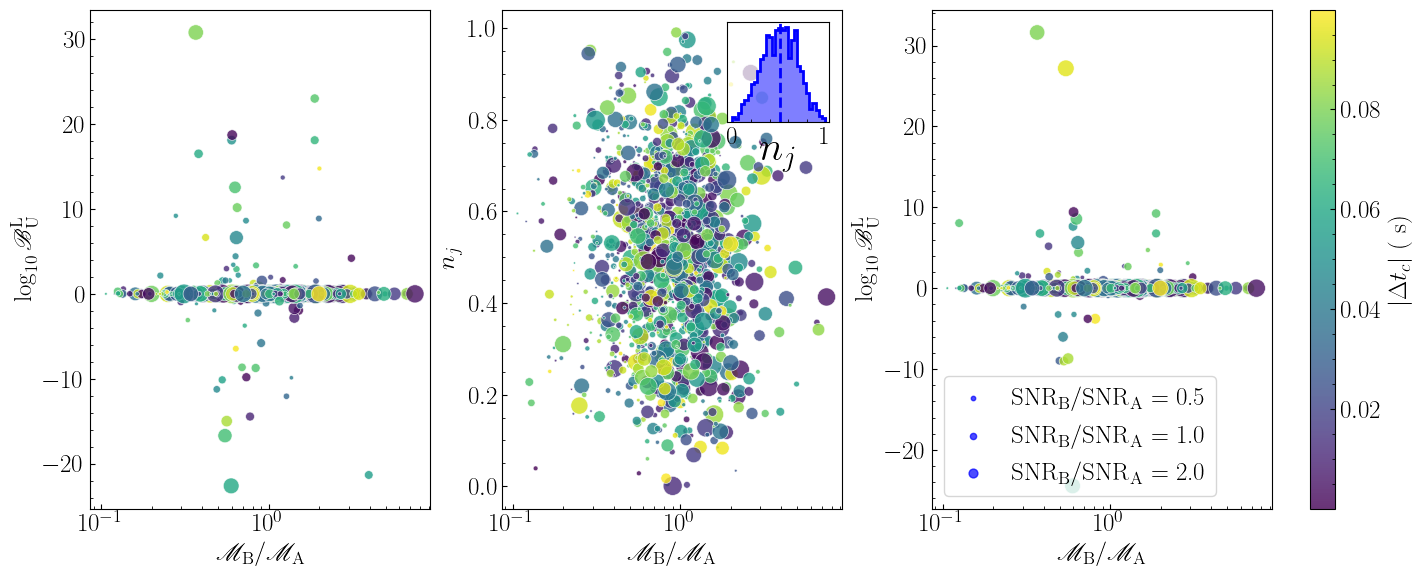

In [38]:
fig, axes = plt.subplots(1, 3, constrained_layout=True)

sizes = 200 * (snr_b/snr_a / np.max(snr_b/snr_a))

log_bayes_factor_ml2_diff = snr_a**2*(match_ml2**2-match**2)/10/np.log(10)

scatter = axes[0].scatter(mchirp_b/mchirp_a, log_bayes_factor_ml2_diff, c=np.abs(delta_tc),
                        cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                        edgecolor='white', linewidth=0.5)
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[0].set_ylabel('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')
#axes[0].set_title('Estimated $\\log_{10}\\mathscr{B}_{{L}}-\\log_{10}\\mathscr{B}_0$ Values')

axes[0].set_axisbelow(True)

scatter1 = axes[1].scatter(mchirp_b/mchirp_a, n_ml2c, c=np.abs(delta_tc),
                        cmap=color_palette['colormap'], s=sizes, alpha=0.8, 
                        edgecolor='white', linewidth=0.5)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[1].set_ylabel('$n_j$')
#axes[1].set_title('Morse Index $n_j$ values')

axes[1].set_axisbelow(True)

log_bayes_factor_ml2c_diff = np.sqrt(snr_a**2+snr_b**2)*(match_ml2c**2-match**2)/2/np.log(10)

scatter2 = axes[2].scatter(mchirp_b/mchirp_a, log_bayes_factor_ml2c_diff, c=np.abs(delta_tc),
                        cmap=color_palette['colormap'], s=sizes, alpha=0.8,
                        edgecolor='white', linewidth=0.5)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\\mathscr{M}_{\\rm B}/\\mathscr{M}_{\\rm A}$')
axes[2].set_ylabel('$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$')
#axes[2].set_title('Estimated $\\log_{10}\\mathscr{B}_{{L}}-\\log_{10}\\mathscr{B}_0$ Values')

axes[2].set_axisbelow(True)

cbar1 = plt.colorbar(scatter2, ax=[axes[1], axes[2]])
cbar1.set_label('$|\\Delta t_c|$ ({~\\rm s})')
snr_markers = []
for snr_val in [0.5, 1.0, 2.0]:
    size = 200 * (snr_val / np.max(snr_b/snr_a))
    snr_markers.append(plt.scatter([], [], c='blue', alpha=0.7, s=size,
                                 label=f'$\\mathrm{{SNR}}_{{\\rm B}}/\\mathrm{{SNR}}_{{\\rm A}}$ = {snr_val:.1f}'))
axes[2].legend(handles=snr_markers)

ax_inset = inset_axes(axes[1], width="30%", height="20%", loc='upper right', 
                      bbox_to_anchor=(0, 0, 1, 1), bbox_transform=axes[1].transAxes)

ax_inset.patch.set_alpha(0.7)
ax_inset.hist(n_ml2c, bins=30, histtype='step', lw=2, color='blue', density=True)
ax_inset.hist(n_ml2c, bins=30, histtype='stepfilled', alpha=0.5, color='blue', density=True)
ax_inset.axvline(np.median(n_ml2c), color='blue', linestyle='--', lw=2)
ax_inset.set_yticks([])
ax_inset.set_xlabel('$n_j$', fontsize=30, labelpad=-10)

plt.show()

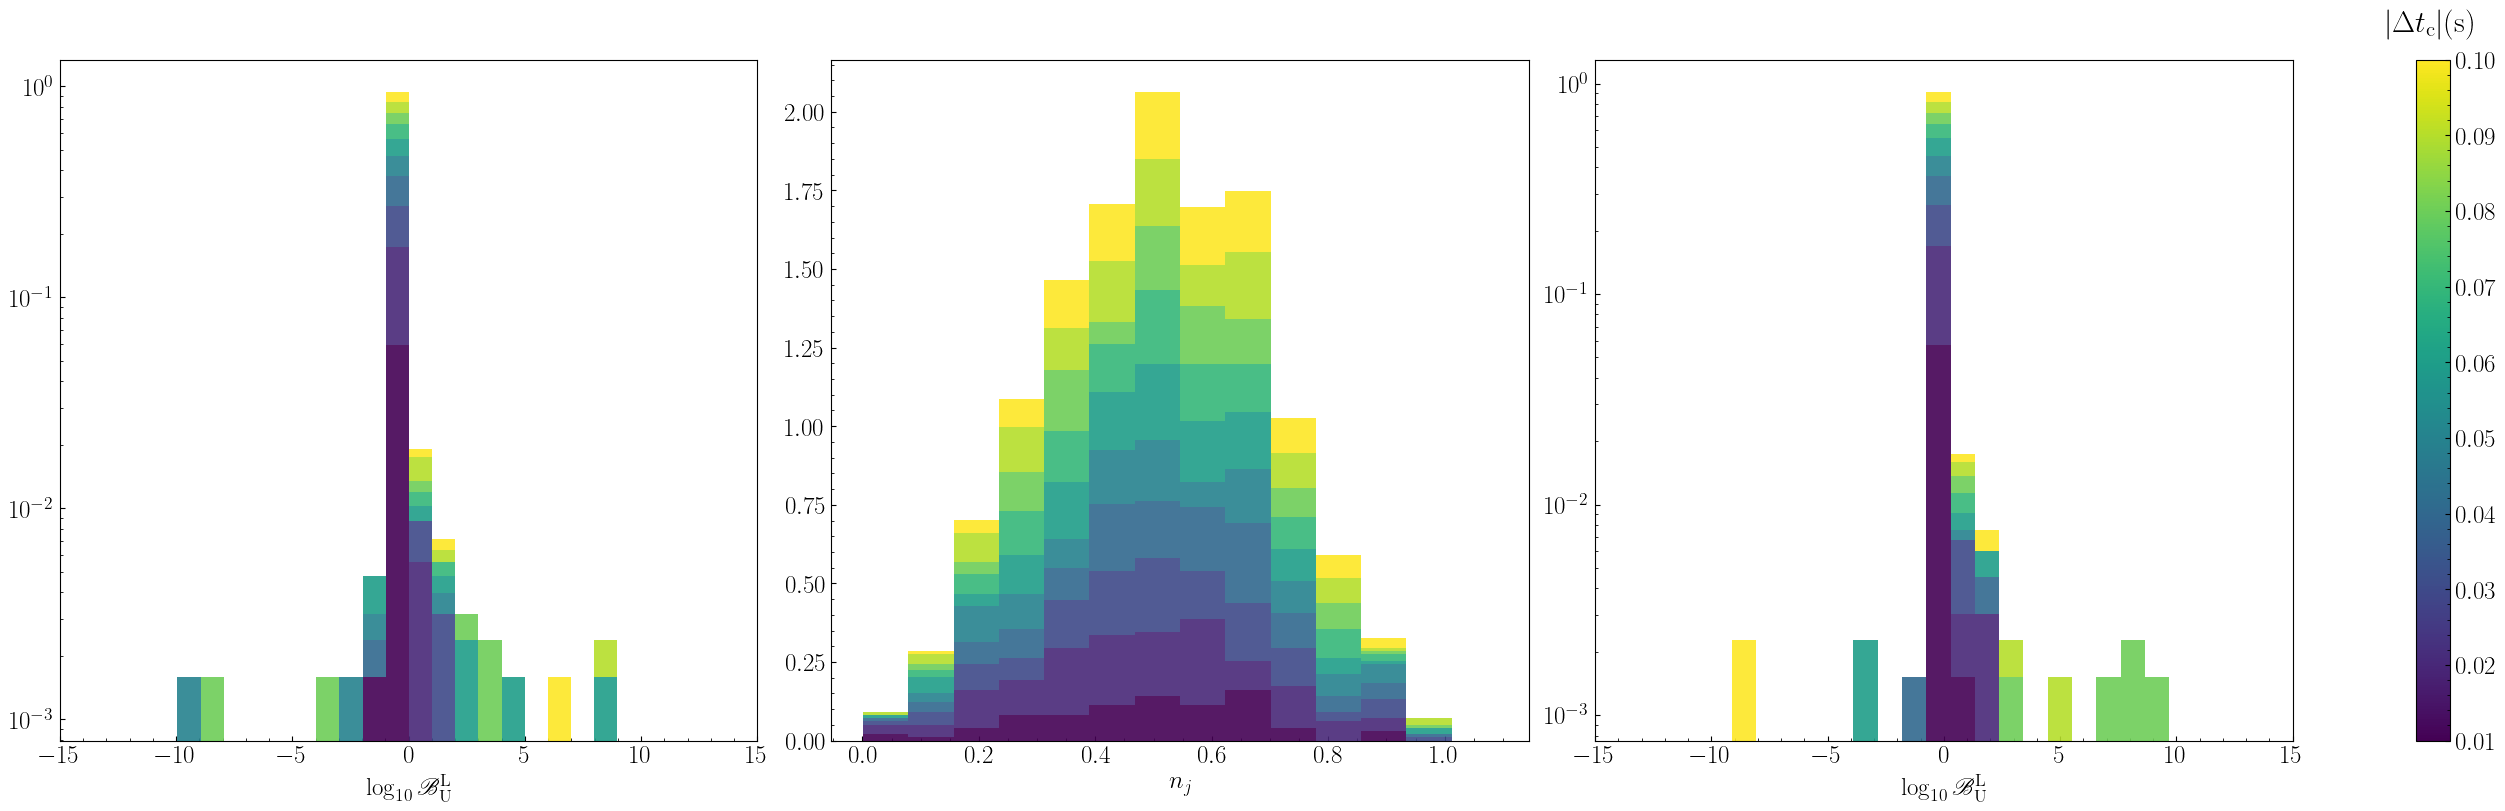

In [39]:
eps = 0.005
centers = np.arange(0.01, 0.101, 0.01)
edges = np.concatenate(([0.], centers - eps, [centers[-1] + eps]))

cmap = matplotlib.colormaps[color_palette['colormap']]
norm = matplotlib.colors.Normalize(vmin=centers[0], vmax=centers[-1])
colors = cmap(norm(centers))

def stacked_counts(x, delta_abs, mask, bins):
    hist_bins = bins
    counts_per_delta = []
    for i in range(len(centers)):
        sel = mask & (delta_abs >= edges[i]) & (delta_abs < edges[i+1])
        if np.any(sel):
            cts, _ = np.histogram(x[sel], bins=hist_bins)
        else:
            cts = np.zeros(len(hist_bins) - 1, dtype=int)
        counts_per_delta.append(cts)
    return np.array(counts_per_delta)

def bins(x, nbins=15, log_scale=True):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if log_scale:
        low = np.min(x) * 0.9
        high = np.max(x) * 1.1
        if low <= 0 or low == high:
            low = np.min(x[x>0]) * 0.9
            high = np.max(x) * 1.1
        return np.geomspace(low, high, nbins)
    else:
        lo = np.min(x) * 1.1 if np.min(x) < 0 else np.min(x) * 0.9
        hi = np.max(x) * 1.1 if np.max(x) > 0 else np.max(x) + 0.1
        if lo == hi:
            lo -= 0.5
            hi += 0.5
        return np.linspace(lo, hi, nbins)

x_list = [log_bayes_factor_ml2_diff, n_ml2c, log_bayes_factor_ml2c_diff]
x_labels = ['$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$', '$n_j$', '$\\log_{10}\\mathscr{B}^{\\rm L}_{\\rm U}$']
log_scales = [False, False, False]

full_mask = np.ones_like(np.asarray(delta_tc), dtype=bool)
delta_abs = np.abs(delta_tc)

fig, axes = plt.subplots(1, 3, figsize=(25, 8), constrained_layout=True)

for ax, x, xlabel, ls in zip(axes, x_list, x_labels, log_scales):
    if x in n_ml2c:
        xbins = bins(x, nbins=15, log_scale=ls)
    else:
        xbins = bins(x, nbins=60, log_scale=ls)

    counts2d = stacked_counts(x, delta_abs, full_mask, xbins)
    counts2d = counts2d / (counts2d.sum() * (xbins[1:][None, :] - xbins[:-1][None, :]))
    bottom = np.zeros(xbins.size - 1)
    for j, cts in enumerate(counts2d):
        centers_x = (xbins[:-1] + xbins[1:]) / 2.0
        widths = (xbins[1:] - xbins[:-1])
        ax.bar(x=centers_x,
               height=cts,
               width=widths,
               bottom=bottom,
               align='center',
               color=colors[j],
               edgecolor='none',
               alpha=0.9)
        bottom = bottom + cts

    if ls:
        ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_axisbelow(True)

axes[0].set_yscale('log')
axes[0].set_xlim(-15, 15)

axes[2].set_yscale('log')
axes[2].set_xlim(-15, 15)

sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right')
cbar.ax.set_title('$|\\Delta t_{\\rm c}| ({\\rm s})$', pad=20)

plt.show()

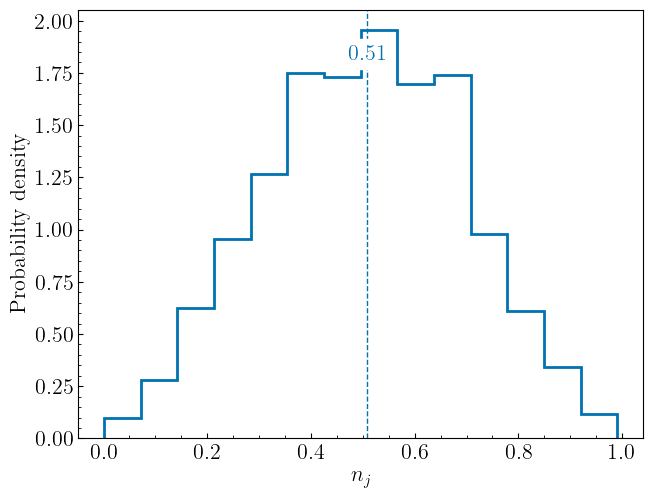

In [40]:
plt.rcParams.update(new_rcParams(width='column'))
fig, ax = plt.subplots()

bins = np.linspace(np.nanmin(n_ml2c), np.nanmax(n_ml2c), 15)

ax.hist(n_ml2c, density=True, bins=bins,histtype='step', linewidth=2, color=color_palette['primary'])

vmed = np.nanmedian(n_ml2c)
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1]*0.92, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xlabel(r'$n_j$')
ax.set_ylabel(r'Probability density')
ax.grid(False)
plt.tight_layout()
plt.savefig('../../output/pe_population/output/TypeIICLensedFFPopParam.pdf')
plt.show()

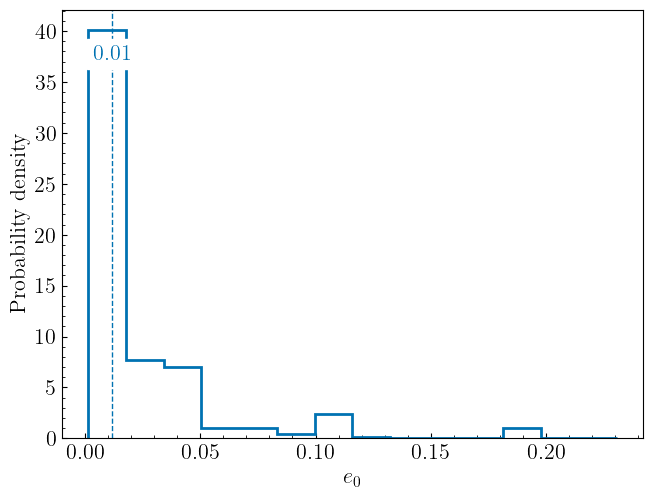

In [41]:
plt.rcParams.update(new_rcParams(width='column'))
fig, ax = plt.subplots()

bins = np.linspace(np.nanmin(e_ecc), np.nanmax(e_ecc), 15)

ax.hist(e_ecc, density=True, bins=bins,histtype='step', linewidth=2, color=color_palette['primary'])

vmed = np.nanmedian(e_ecc)
ax.axvline(vmed, color=color_palette['primary'], linestyle='--', lw=1)
ax.text(vmed, ax.get_ylim()[1]*0.92, f'{vmed:.2f}', color=color_palette['primary'],
        ha='center', va='top', backgroundcolor='white')

ax.set_xlabel(r'$e_0$')
ax.set_ylabel(r'Probability density')
ax.grid(False)
plt.tight_layout()
plt.savefig('../../output/pe_population/output/EccFFPopParam.pdf')
plt.show()